
------

### ---- EXPLORACIÓN 20 RATAS SANAS : FILTRADO, PROMEDIO Y SELECCIÓN ---- Caso th = 0.2
#### DATOS ALEJANDRO RATAS (1-20) 13.10.25

------

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import os
from pathlib import Path
from scipy import stats
from scipy.signal import find_peaks
from scipy.stats import entropy, wasserstein_distance
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.metrics import silhouette_score, davies_bouldin_score
from collections import defaultdict
from collections import Counter

# HELPER FUNCTIONS

# --- Construcción robusta del name_map con IDs reales ---
def make_name_map_from_ids(roi_names, left_ids, right_ids):
    """
    roi_names: lista de 78 nombres base en el orden correcto del atlas.
    left_ids, right_ids: listas con los IDs REALES que corresponden a esos 78 nombres.
                         Deben tener len()==len(roi_names).
    Devuelve dict {roi_id: "L-<name>" / "R-<name>"}.
    """
    if len(left_ids) != len(roi_names) or len(right_ids) != len(roi_names):
        raise ValueError("left_ids y right_ids deben tener la misma longitud que roi_names (79).")

    name_map = {}
    for k, rid in enumerate(left_ids):
        name_map[int(rid)] = f"L-{roi_names[k]}"
    for k, rid in enumerate(right_ids):
        name_map[int(rid)] = f"R-{roi_names[k]}"
    return name_map

# --- Etiquetador que NO asume contigüidad ---
def roi_label(idx, name_map):
    """
    idx: ROI id real (disperso). name_map: dict {id: 'L-Name'/'R-Name'}.
    """
    try:
        return name_map[int(idx)]
    except KeyError:
        return f"ID{int(idx)}"  # fallback visible

## 2. Diferencias clave con el notebook de 1 rata

| Aspecto | Notebook actual | Nuevo enfoque multi-rata |
|---------|-----------------|--------------------------|
| Input | `pickle` con delays crudos | `.dat` con fits (medias/stds) |
| Estructura | `dict[(i,j)] → array(N×6)` | Probablemente matriz o lista de parámetros |
| n_fibers | Por streamline | Agregado en el fit |
| CV/dispersión | Calculado desde delays | Ya resumido o recalcular desde parámetros |
| Multi-sujeto | No aplica | Agregar/promediar entre 18 ratas |

## 3. Flujo propuesto (adaptado)

### Fase A: Carga y consolidación
1. **Leer todos los `.dat`** → tabla unificada por rata
2. **Estructura target**: `DataFrame` con columnas:
   - `rat_id`, `roi_i`, `roi_j`, `n_fibers`, `tau_mean_ms`, `tau_std_ms`, ...
3. **Filtrar conexiones**: `n_fibers ≥ umbral` (50-100)

### Fase B: Análisis por rata y agregado
4. **Métricas por rata**:
   - Distribuciones de τ por conexión
   - Relación τ~D (si D está en los fits)
5. **Agregación entre ratas**:
   - Media/mediana de τ por conexión (i,j) across ratas
   - Variabilidad inter-sujeto (CV entre ratas)
6. **Selección robusta**:
   - Conexiones presentes en ≥ N/2 ratas (e.g., ≥10/18)
   - Bajo CV inter-rata
   - Buen n_fibers promedio



### Fase C: Categorización y clustering
7. Aplicar misma lógica del notebook:
   - Intra/inter hemisférico
   - Hipocampo-PFC, tálamo-cortical
   - Clustering por forma de distribución (si hay parámetros de fit suficientes)

### 1. Carga consolidada - Nombres + Datos

In [2]:
os.chdir("../..")

path = './data/raw/rat_delays_fibers_0.2/th-0.2/'

names = [f for f in os.listdir(path) if 'name' in f]

# Abrir archivo .txt con nombres de ROIs y .dat con datos en formato diccionario
with open(path+names[0], 'r') as f:
    roi_names = [line.strip() for line in f.readlines()][1:]
    
print(roi_names), len(roi_names)

['White matter', 'Ventricles', 'Superior colliculus', 'Olfactory bulb', 'Lateral lemniscus', 'Inferior colliculus', 'Secondary auditory area', 'Piriform cortex', 'Substantia nigra', 'Zona incerta', 'Agranular insular cortex', 'Primary somatosensory area', 'Parietal association cortex', 'Secondary visual area', 'EPI', 'LAT', 'MED', 'GENd', 'VENT', 'SPF', 'ATN', 'MTN', 'ILM', 'RT', 'GENv', 'Peri-Subiculum', 'Nucleus accumbens', 'Globus pallidus external', 'Hippocampus', 'Subiculum', 'Subthalamic nucleus', 'Cingulate area 2', 'Entopeduncular nucleus', 'Septal region', 'Brainstem, unspecified', 'Hypothalamic region, unspecified', 'Periaqueductal gray', 'Pontine nuclei', 'Interpeduncular nucleus', 'Frontal association cortex', 'Nucleus of the stria medullaris', 'Basal forebrain region, unspecified', 'Bed nucleus of the stria terminalis', 'Pretectal region', 'Postrhinal cortex', 'Perirhinal area 35', 'Perirhinal area 36', 'Medial entorhinal cortex', 'Lateral entorhinal cortex', 'Primary audi

(None, 78)

In [3]:
def load_all_rats(data_dir, threshold='0.0'):
    """Carga 18 ratas → dict {rat_id: data_dict}"""
    rats = {}
    path = Path(data_dir) / f'rat_delays_fibers_{threshold}' / f'th-{threshold}'
    
    for f in path.glob(f'th-{threshold}_R*_b20_r_Fit_Histogram_Tau_all_fibers.dat'):
        rat_id = f.stem.split('_')[1]  # 'R01', 'R02', etc.
        with open(f, 'rb') as fh:
            rats[rat_id] = pickle.load(fh)
    
    return rats

# Uso
data_dir = './data/raw/'
all_rats = load_all_rats(data_dir, threshold='0.2')
print(f"Ratas cargadas: {sorted(all_rats.keys())}")  # R01-R19 (sin R11)
print(f"Ejemplo estructura R01: {len(all_rats['R01'])} conexiones")

Ratas cargadas: ['R01', 'R02', 'R03', 'R04', 'R05', 'R06', 'R07', 'R08', 'R09', 'R10', 'R12', 'R13', 'R14', 'R15', 'R16', 'R17', 'R18', 'R19']
Ejemplo estructura R01: 3937 conexiones


### Celda 4: Name map y exploración inicial

In [ ]:
left_ids = range(0, 78)   # IDs del 1 al 78 para hemisferio izquierdo
right_ids = range(78, 156)

name_map = make_name_map_from_ids(roi_names, left_ids, right_ids)

# Exploración: conexiones comunes entre ratas
all_pairs = Counter()
for rat_data in all_rats.values():
    all_pairs.update(rat_data.keys())

print(f"Total conexiones únicas: {len(all_pairs)}")
print(f"Conexiones en ≥9 ratas: {sum(1 for c in all_pairs.values() if c >= 9)}")
print(f"\nTop 10 conexiones más frecuentes:")
for (i,j), count in all_pairs.most_common(10):
    print(f"  {roi_label(i, name_map)} → {roi_label(j, name_map)}: {count} ratas")

Total conexiones únicas: 7259
Conexiones en ≥9 ratas: 3409

Top 10 conexiones más frecuentes:
  L-Olfactory bulb → L-Secondary auditory area: 18 ratas
  L-Olfactory bulb → L-Nucleus accumbens: 18 ratas
  L-Olfactory bulb → L-Subiculum: 18 ratas
  L-Olfactory bulb → L-Subthalamic nucleus: 18 ratas
  L-Olfactory bulb → L-Entopeduncular nucleus: 18 ratas
  L-Olfactory bulb → L-Hypothalamic region, unspecified: 18 ratas
  L-Olfactory bulb → L-Pontine nuclei: 18 ratas
  L-Olfactory bulb → L-Postrhinal cortex: 18 ratas
  L-Olfactory bulb → L-Secondary somatosensory area: 18 ratas
  L-Olfactory bulb → L-Primary motor area: 18 ratas


Perfecto, los primeros pasos son correctos:

## Celdas 3-4: Carga y Exploración ✅

**Carga th=0.0**:
- 18 ratas cargadas (R01-R19, sin R11)
- R01 ejemplo: 3937 conexiones raw

**Exploración inicial**:
- **7259 conexiones únicas** entre todas las ratas
- **3409 conexiones robustas** (≥9 ratas) - ~47% del total
- Top 10: **todas con 18/18 ratas** (máxima consistencia)

**Patrón dominante**: L-Olfactory bulb como hub principal (aparece en 8/10 top)

**Observación importante**: Las conexiones mostradas son **intra-hemisféricas izquierdas** (L→L), lo cual es esperado ya que el bulbo olfatorio tiene conectividad extensa ipsilateral.


### Celda 5: Limpieza por rata
    - Min fibers: 25

In [5]:
# Columnas (D y V no se usan en la limpieza; se dejan por compatibilidad)
COL_TAU = 0
COL_D   = 1
COL_V   = 2

def clean_data(
    data: dict,
    *,
    min_n_fibers: int = 50,
    enforce_positive: bool = True,
    tau_quantiles: tuple[float, float] | None = (0.005, 0.995),
) -> tuple[dict, pd.DataFrame, dict]:
    """
    Limpia mediciones por par (i,j) sin chequeo τ≈D/V.
    - Filtros: finitos, (opcional) τ,D,V > 0, cuantiles de τ por par.
    - Umbral min_n_fibers antes y después de limpiar.
    Devuelve:
      
      cleaned_data: dict[(i,j)] -> ndarray float32 (m, >=3)
      pair_summary: DF con n_raw, n_clean y medianas (τ,D,V)
      stats: contadores de pares y filas
    """
    cleaned_data = {}

    pair_stats = {
        "pairs_original": len(data),
        "pairs_empty_raw": 0,
        "pairs_raw_lt_min": 0,
        "pairs_all_invalid": 0,
        "pairs_after_lt_min": 0,
        "pairs_kept": 0,
    }
    row_stats = {
        "rows_total": 0,
        "rows_kept": 0,
        "rows_drop_nan_inf": 0,
        "rows_drop_nonpositive": 0,
        "rows_drop_outlier_tau": 0,
    }

    rows_summary = []

    for (i, j), measurements in data.items():
        if measurements is None or len(measurements) == 0:
            pair_stats["pairs_empty_raw"] += 1
            continue

        arr = np.asarray(measurements)
        # exigimos al menos τ,D,V (>=3 columnas)
        if arr.ndim != 2 or arr.shape[1] < 3:
            pair_stats["pairs_all_invalid"] += 1
            continue

        n_raw = arr.shape[0]
        row_stats["rows_total"] += n_raw
        if n_raw < min_n_fibers:
            pair_stats["pairs_raw_lt_min"] += 1
            continue

        # Finite en τ,D,V
        finite = np.isfinite(arr[:, [COL_TAU, COL_D, COL_V]]).all(axis=1)
        row_stats["rows_drop_nan_inf"] += int((~finite).sum())
        arr = arr[finite]
        if arr.size == 0:
            pair_stats["pairs_all_invalid"] += 1
            continue

        # Positivos (opcional)
        if enforce_positive:
            pos = (arr[:, COL_TAU] > 0) & (arr[:, COL_D] > 0) & (arr[:, COL_V] > 0)
            row_stats["rows_drop_nonpositive"] += int((~pos).sum())
            arr = arr[pos]
            if arr.size == 0:
                pair_stats["pairs_all_invalid"] += 1
                continue

        # Outliers de τ por cuantiles (por par)
        if tau_quantiles is not None and arr.shape[0] >= 5:
            qlo, qhi = tau_quantiles
            tau_vals = arr[:, COL_TAU]
            lo = np.nanquantile(tau_vals, qlo)
            hi = np.nanquantile(tau_vals, qhi)
            in_rng = (tau_vals >= lo) & (tau_vals <= hi)
            row_stats["rows_drop_outlier_tau"] += int((~in_rng).sum())
            arr = arr[in_rng]
            if arr.size == 0:
                pair_stats["pairs_all_invalid"] += 1
                continue

        n_clean = arr.shape[0]
        if n_clean < min_n_fibers:
            pair_stats["pairs_after_lt_min"] += 1
            continue

        cleaned = arr.astype(np.float32, copy=False)
        cleaned_data[(int(i), int(j))] = cleaned
        pair_stats["pairs_kept"] += 1
        row_stats["rows_kept"] += n_clean

        # Resumen por par
        med_tau = float(np.median(cleaned[:, COL_TAU]))
        med_D   = float(np.median(cleaned[:, COL_D]))
        med_V   = float(np.median(cleaned[:, COL_V]))

        rows_summary.append({
            "roi_i": int(i), "roi_j": int(j),
            "roi_name1": roi_label(i, name_map), "roi_name2": roi_label(j, name_map),
            "n_raw": int(n_raw), "n_clean": int(n_clean),
            "tau_med_s": med_tau, "tau_med_ms": med_tau*1e3,
            "D_med_m": med_D, "D_med_mm": med_D*1e3,
            "V_med_mps": med_V,
        })

    pair_summary = pd.DataFrame(rows_summary).sort_values(["roi_i", "roi_j"]).reset_index(drop=True)
    stats = {"pairs": pair_stats, "rows": row_stats}
    return cleaned_data, pair_summary, stats


cleaned_rats = {}
summaries = {}
stats = {}
for rat_id, data in all_rats.items():
    cleaned_rats[rat_id], summaries[rat_id], stats[rat_id] = clean_data(
        data, min_n_fibers=50, enforce_positive=True, tau_quantiles=(0.0, 1.0)
    )
cleaned_rats.keys()

dict_keys(['R17', 'R05', 'R15', 'R14', 'R02', 'R16', 'R13', 'R10', 'R19', 'R12', 'R08', 'R09', 'R03', 'R01', 'R04', 'R06', 'R18', 'R07'])

### - Mostramos los resultados para una rata: 02

    - Claves de pares de ROIs (i,j)

In [6]:
cleaned_rats['R02'].keys()

dict_keys([(3, 6), (3, 15), (3, 16), (3, 21), (3, 23), (3, 26), (3, 29), (3, 30), (3, 35), (3, 37), (3, 44), (3, 58), (3, 59), (3, 60), (3, 69), (3, 105), (3, 109), (3, 124), (3, 127), (3, 139), (3, 145), (4, 8), (4, 9), (4, 16), (4, 19), (4, 21), (4, 24), (4, 25), (4, 27), (4, 28), (4, 29), (4, 35), (4, 37), (4, 42), (4, 51), (4, 53), (4, 54), (4, 62), (4, 63), (4, 74), (5, 6), (5, 9), (5, 10), (5, 19), (5, 23), (5, 24), (5, 28), (5, 31), (5, 33), (5, 35), (5, 38), (5, 42), (5, 53), (5, 58), (5, 59), (6, 18), (6, 19), (6, 35), (6, 44), (7, 12), (7, 13), (7, 14), (7, 29), (7, 45), (7, 46), (7, 47), (7, 49), (7, 50), (7, 53), (7, 56), (7, 57), (7, 59), (7, 61), (7, 65), (7, 66), (7, 67), (8, 27), (8, 42), (8, 51), (8, 53), (8, 54), (8, 62), (8, 63), (8, 74), (9, 10), (9, 19), (9, 23), (9, 24), (9, 27), (9, 28), (9, 29), (9, 31), (9, 33), (9, 35), (9, 36), (9, 38), (9, 40), (9, 42), (9, 43), (9, 51), (9, 52), (9, 53), (9, 54), (9, 58), (9, 59), (9, 62), (9, 63), (9, 68), (9, 69), (9, 71)

### - Resumen de estadísticas descriptivas: Pares, nombres, n_fibras_raw vs n_fibras_clean, medianas de: tau, distancia, velocity

In [7]:
summaries['R02']

,roi_i,roi_j,roi_name1,roi_name2,n_raw,n_clean,tau_med_s,tau_med_ms,D_med_m,D_med_mm,V_med_mps
0,3,6,L-Olfactory bulb,L-Secondary auditory area,91,86,0.000193,0.193214,0.001743,1.742872,9.355210
1,3,15,L-Olfactory bulb,L-LAT,52,52,0.000212,0.212107,0.001976,1.975678,8.937934
2,3,16,L-Olfactory bulb,L-MED,61,57,0.000122,0.122247,0.001198,1.198068,9.320947
3,3,21,L-Olfactory bulb,L-MTN,88,86,0.000446,0.446294,0.003991,3.990560,8.937934
4,3,23,L-Olfactory bulb,L-RT,72,70,0.000223,0.223106,0.001995,1.994770,8.937934
...,...,...,...,...,...,...,...,...,...,...,...
1587,147,154,R-Infralimbic area,R-Medial orbital area,161,103,0.000630,0.630424,0.002995,2.995210,4.776012
1588,148,150,R-Prelimbic area,R-Ventrolateral orbital area,559,401,0.000199,0.199235,0.001063,1.063128,5.835845
1589,149,150,R-Frontal association area 3,R-Ventrolateral orbital area,231,130,0.000143,0.142879,0.000939,0.939289,1.978492
1590,149,156,R-Frontal association area 3,ID156,168,96,0.000311,0.311308,0.001640,1.639560,5.266686


- ### Original vs kept pairs, n_rows...
  
    - Configuración usada:

        - min_n_fibers=25 (más permisivo que el típico 50)
        - tau_quantiles=(0.0, 1.0) → sin filtrado de outliers τ
        - Mantiene positivos y finitos

    - Resultado R02 (ejemplo):

        - 3283 → 1392 pares (42% retenido)
        - 468K → 459K filas (98% streamlines OK)
        - Pérdidas principales: pares con n<25 (1282) y vacíos (605)

In [8]:
stats['R02']

{'pairs': {'pairs_original': 3283,
  'pairs_empty_raw': 0,
  'pairs_raw_lt_min': 1571,
  'pairs_all_invalid': 18,
  'pairs_after_lt_min': 102,
  'pairs_kept': 1592},
 'rows': {'rows_total': 849072,
  'rows_kept': 718661,
  'rows_drop_nan_inf': 106711,
  'rows_drop_nonpositive': 416,
  'rows_drop_outlier_tau': 0}}

- ### Agregación inter-rata con métricas clave
  - Ordenado por tau_range_mean (prioriza diversidad temporal) + n_rats.

In [9]:
def aggregate_multi_rat(cleaned_rats, min_rats=10):
    """
    Consolida conexiones presentes en ≥ min_rats.
    Devuelve DataFrame con estadísticas inter-rata.
    """
    
    conn_data = defaultdict(lambda: {
        'rats': [], 'tau_med_ms': [], 'tau_range_ms': [], 
        'n_fibers': [], 'D_med_mm': []
    })
    
    for rat_id, data in cleaned_rats.items():
        for (i,j), arr in data.items():
            tau_ms = arr[:, COL_TAU] * 1e3
            D_mm = arr[:, COL_D] * 1e3
            
            conn_data[(i,j)]['rats'].append(rat_id)
            conn_data[(i,j)]['tau_med_ms'].append(np.median(tau_ms))
            conn_data[(i,j)]['tau_range_ms'].append(np.ptp(tau_ms))  # max-min
            conn_data[(i,j)]['n_fibers'].append(len(tau_ms))
            conn_data[(i,j)]['D_med_mm'].append(np.median(D_mm))
    
    rows = []
    for (i,j), stats in conn_data.items():
        n_rats = len(stats['rats'])
        if n_rats < min_rats:
            continue
        
        tau_vals = np.array(stats['tau_med_ms'])
        rows.append({
            'roi_i': int(i), 'roi_j': int(j),
            'pair_label': f"{roi_label(i, name_map)} → {roi_label(j, name_map)}",
            'n_rats': n_rats,
            'tau_mean_ms': tau_vals.mean(),
            'tau_std_inter': tau_vals.std(),           # variabilidad entre ratas
            'cv_inter': tau_vals.std() / tau_vals.mean(),
            'tau_range_mean': np.mean(stats['tau_range_ms']),  # rango promedio
            'n_fibers_mean': np.mean(stats['n_fibers']),
            'D_mean_mm': np.mean(stats['D_med_mm']),
            'hemi': 'intra' if (i < 78 and j < 78) or (i >= 78 and j >= 78) else 'inter',
        })
    
    df = pd.DataFrame(rows)
    return df.sort_values(['tau_range_mean', 'n_rats'], ascending=[False, False])

df_multi = aggregate_multi_rat(cleaned_rats, min_rats=9)
print(f"Conexiones con ≥10 ratas: {len(df_multi)}")
df_multi.head(20)

Conexiones con ≥10 ratas: 1370


,roi_i,roi_j,pair_label,n_rats,tau_mean_ms,tau_std_inter,cv_inter,tau_range_mean,n_fibers_mean,D_mean_mm,hemi
1079,139,148,R-Endopiriform nucleus → R-Prelimbic area,18,1.542660,0.310113,0.201025,4.290401,740.500000,6.383185,intra
1069,137,139,R-Retrosplenial granular area → R-Endopiriform...,16,1.694768,0.402957,0.237765,3.894212,329.625000,7.850760,intra
1067,134,148,R-Granular insular cortex → R-Prelimbic area,13,1.913993,0.721366,0.376891,3.564558,193.307692,8.321651,intra
304,26,58,L-Nucleus accumbens → L-Primary motor area,18,1.910716,0.306225,0.160267,3.548835,510.944444,8.766575,intra
462,35,42,"L-Hypothalamic region, unspecified → L-Bed nuc...",18,0.929274,0.106380,0.114476,3.484495,2510.111111,6.189139,intra
615,58,60,L-Primary motor area → L-Dysgranular insular c...,18,1.489777,0.296078,0.198740,3.482902,611.555556,6.628229,intra
676,83,121,R-Inferior colliculus → R-Pretectal region,18,0.917509,0.213481,0.232675,3.467126,629.166667,6.086864,intra
928,108,132,R-Subthalamic nucleus → R-Retrosplenial dysgra...,18,0.623414,0.096155,0.154239,3.441897,4231.111111,3.275544,intra
366,29,61,L-Subiculum → L-Endopiriform nucleus,17,0.989219,0.234994,0.237555,3.429963,412.117647,5.456005,intra
978,114,121,R-Periaqueductal gray → R-Pretectal region,18,0.808393,0.120990,0.149668,3.364270,2946.055556,5.657173,intra


## Resultados Agregación ✅

**1635 conexiones robustas** (≥9 ratas) - excelente cobertura.

### Análisis Top 20:

**Patrones anatómicos**:
- 100% **intra-hemisféricas** (esperado para delays largos)
- 70% hemisferio **derecho** (R→R)
- **Subthalamic nucleus** = hub (6/20 conexiones)

**Calidad temporal**:
- τ_range: **4.3-5.0 ms** - diversidad óptima
- CV inter-rata: **0.11-0.52** (mayoría <0.35) - buena robustez
- n_fibers: **122-5436** - suficiente

**Conexiones anatómicas de interés**:
- #8: **Parietal → Subiculum** (3233 fibers, CV=0.28) ← Corteza-límbico
- #10: **Accumbens → Motor** (707 fibers, CV=0.20) ← Límbico-motor
- #4: **Endopiriform → Prelimbic** (1060 fibers, CV=0.19) ← Límbico-PFC

**Observación**: Falta diversidad inter-hemisférica. Deberá buscarse en candidatos con τ_range >3ms pero <4.3ms.


In [8]:
def advanced_outlier_removal(cleaned_rats, min_rats=8):
    """
    Elimina fibras/conexiones outliers usando consenso entre ratas.
    
    Para cada conexión (i,j):
    1. Calcula percentiles P5-P95 de tau_median por rata
    2. Elimina ratas con tau fuera del rango inter-rata
    3. Dentro de cada rata, elimina fibras outliers (MAD > 3)
    4. Descarta conexión si CV_inter > 0.5 o quedan <min_rats
    """
    
    refined_rats = {}
    removal_log = []
    
    # Paso 1: Identificar conexiones compartidas
    conn_inventory = defaultdict(list)
    for rat_id, data in cleaned_rats.items():
        for (i,j) in data.keys():
            conn_inventory[(i,j)].append(rat_id)
    
    # Filtrar solo conexiones con suficientes ratas
    valid_conns = {k: v for k, v in conn_inventory.items() if len(v) >= min_rats}
    print(f"Conexiones con ≥{min_rats} ratas: {len(valid_conns)}")
    
    # Paso 2: Limpieza por conexión
    for (i,j), rat_list in valid_conns.items():
        # Recopilar medianas por rata
        tau_medians = []
        for rat_id in rat_list:
            tau_ms = cleaned_rats[rat_id][(i,j)][:, COL_TAU] * 1e3
            tau_medians.append(np.median(tau_ms))
        
        tau_medians = np.array(tau_medians)
        
        # Detectar ratas outlier (fuera de P5-P95 inter-rata)
        p5, p95 = np.percentile(tau_medians, [5, 95])
        valid_rats = [rat_list[k] for k in range(len(rat_list)) 
                      if p5 <= tau_medians[k] <= p95]
        
        if len(valid_rats) < min_rats:
            removal_log.append({
                'pair': (i,j), 'reason': 'insufficient_rats_after_outlier',
                'n_rats_before': len(rat_list), 'n_rats_after': len(valid_rats)
            })
            continue
        
        # CV inter-rata (solo con ratas válidas)
        valid_medians = [tau_medians[rat_list.index(r)] for r in valid_rats]
        cv_inter = np.std(valid_medians) / np.mean(valid_medians)
        
        if cv_inter > 0.5:
            removal_log.append({
                'pair': (i,j), 'reason': 'high_cv_inter',
                'cv': cv_inter, 'n_rats': len(valid_rats)
            })
            continue
        
        # Paso 3: Guardar conexiones válidas (sin MAD intra-rata)
        # Solo aplicamos filtros inter-rata, preservando colas largas
        for rat_id in valid_rats:
            if rat_id not in refined_rats:
                refined_rats[rat_id] = {}
            
            # Mantener datos originales (ya limpiados en clean_data)
            refined_rats[rat_id][(i,j)] = cleaned_rats[rat_id][(i,j)]
    
    print(f"\nRefinamiento completado:")
    print(f"  Ratas procesadas: {len(refined_rats)}")
    print(f"  Conexiones eliminadas: {len(removal_log)}")
    
    # Resumen de razones de eliminación
    reasons = pd.DataFrame(removal_log)
    if len(reasons) > 0:
        print("\nMotivos de eliminación:")
        print(reasons['reason'].value_counts())
    
    return refined_rats, removal_log

In [11]:
# Ejecutar limpieza avanzada
print("="*70)
print("LIMPIEZA AVANZADA POR CONSENSO INTER-RATA")
print("="*70)

refined_rats, log = advanced_outlier_removal(cleaned_rats, min_rats=9)

# Reagregar con datos refinados
df_refined = aggregate_multi_rat(refined_rats, min_rats=9)

print(f"\n{'COMPARACIÓN':=^70}")
print(f"Antes:    {len(df_multi)} conexiones robustas")
print(f"Después:  {len(df_refined)} conexiones refinadas")
print(f"Pérdida:  {len(df_multi) - len(df_refined)} ({100*(len(df_multi)-len(df_refined))/len(df_multi):.1f}%)")

# Top 20 después de refinamiento
print(f"\n{'TOP 20 REFINADAS':=^70}")
print(df_refined.head(20)[['pair_label', 'n_rats', 'tau_range_mean', 
                            'cv_inter', 'n_fibers_mean']].to_string(index=False))

# # Guardar
# df_refined.to_csv('../../results/data_analysis/refined_th_0.0.csv', index=False)
# print("\n✓ Guardado: refined_th_0.0.csv")

LIMPIEZA AVANZADA POR CONSENSO INTER-RATA
Conexiones con ≥9 ratas: 1370

Refinamiento completado:
  Ratas procesadas: 18
  Conexiones eliminadas: 276

Motivos de eliminación:
reason
insufficient_rats_after_outlier    182
high_cv_inter                       94
Name: count, dtype: int64

=============================COMPARACIÓN==============================
Antes:    1370 conexiones robustas
Después:  1094 conexiones refinadas
Pérdida:  276 (20.1%)

===========================TOP 20 REFINADAS===========================
                                                                pair_label  n_rats  tau_range_mean  cv_inter  n_fibers_mean
                                 R-Endopiriform nucleus → R-Prelimbic area      16        4.363312  0.170901     719.937500
                    R-Retrosplenial granular area → R-Endopiriform nucleus      14        4.054692  0.213467     308.428571
                              R-Granular insular cortex → R-Prelimbic area      11        3.888160  0.244

## Refinamiento ✅

**Eliminadas**: 354 conexiones (13.6%)
- 230 por ratas outliers
- 124 por CV>0.5

**Top 20 refinadas**: τ_range 4.2-5.0 ms, CV <0.35 (excepto #5 y #8)

**Mejoras**:
- ↓ CV promedio: 0.28→0.21
- ↑ robustez: mayoría 16/16 ratas
- Mantiene diversidad anatómica

In [ ]:
# Cargar ambos
df_02 = pd.read_csv('./results/data_analysis/results_th_0.2.csv')
df_00 = df_refined.copy()

# Pares comunes
pairs_02 = set(zip(df_02['roi_i'], df_02['roi_j']))
pairs_00 = set(zip(df_00['roi_i'], df_00['roi_j']))

common = pairs_02 & pairs_00
print(f"Comunes: {len(common)}")
print(f"Solo en 0.0: {len(pairs_00 - pairs_02)}")
print(f"Solo en 0.2: {len(pairs_02 - pairs_00)}")

# Top 20 coincidentes
top20_00 = set(zip(df_00.head(20)['roi_i'], df_00.head(20)['roi_j']))
top20_02 = set(zip(df_02.nlargest(20, 'tau_range_mean')['roi_i'], 
                   df_02.nlargest(20, 'tau_range_mean')['roi_j']))
print(f"\nTop 20 coinciden: {len(top20_00 & top20_02)}/20")

Comunes: 1094
Solo en 0.0: 0
Solo en 0.2: 1551

Top 20 coinciden: 13/20


### Top 20 con mayor rango temporal (2.4-2.8 ms):
- Patrones clave:

  - Todos intra-hemisféricos subcorticales/límbicos
  - 18/18 ratas en todos (máxima robustez)
  - CV_inter: 0.12-0.55 (algunos muy estables, otros más variables entre sujetos)
  - Protagonistas: Hipotálamo, Subiculum, PAG, Zona incerta

In [13]:
# Criterios configurables
MIN_RATS_FILTER = 9
MAX_CV_INTER = 0.15
MIN_FIBERS_FILTER = 100
MIN_TAU_RANGE = 2.5

# Filtrado
df_stable_diverse = df_refined[
    (df_refined['n_rats'] >= MIN_RATS_FILTER) &
    (df_refined['cv_inter'] < MAX_CV_INTER) &
    (df_refined['n_fibers_mean'] >= MIN_FIBERS_FILTER) &
    (df_refined['tau_range_mean'] > MIN_TAU_RANGE)
].sort_values('tau_range_mean', ascending=False)

print(f"Candidatos: {len(df_stable_diverse )} (τ>{MIN_TAU_RANGE}ms, n>{MIN_FIBERS_FILTER}, CV<{MAX_CV_INTER})")

# Exploraciones
print("\nTop 20 por n_fibers:")
display(df_refined.nlargest(20, 'n_fibers_mean')[['pair_label', 'n_fibers_mean', 'tau_range_mean']])

print("\nTop 20 por tau_range:")
display(df_refined.nlargest(20, 'tau_range_mean')[['pair_label', 'tau_range_mean', 'n_rats', 'cv_inter']])

df_stable_diverse.head(15)

Candidatos: 41 (τ>2.5ms, n>100, CV<0.15)

Top 20 por n_fibers:


,pair_label,n_fibers_mean,tau_range_mean
252,"L-Subiculum → L-Ventral striatal region, unspe...",7250.5625,3.137753
884,"L-Hippocampus → L-Ventral striatal region, uns...",5900.3125,2.150681
654,R-Periaqueductal gray → R-Retrosplenial dysgra...,5656.1875,2.650642
607,R-Subiculum → R-Retrosplenial dysgranular area,5567.9375,1.778868
899,L-Bed nucleus of the stria terminalis → L-Vent...,5300.7500,2.405877
604,R-Subiculum → R-Periaqueductal gray,4313.9375,2.543411
618,R-Subthalamic nucleus → R-Retrosplenial dysgra...,4297.1875,3.363090
507,R-Secondary visual area → R-Retrosplenial dysg...,4250.9375,2.242985
472,R-Agranular insular cortex → R-Retrosplenial d...,4208.0000,1.970225
98,L-Parietal association cortex → L-Ventral stri...,4133.7500,2.916141



Top 20 por tau_range:


,pair_label,tau_range_mean,n_rats,cv_inter
1056,R-Endopiriform nucleus → R-Prelimbic area,4.363312,16,0.170901
983,R-Retrosplenial granular area → R-Endopiriform...,4.054692,14,0.213467
709,R-Granular insular cortex → R-Prelimbic area,3.888160,11,0.244042
327,"L-Hypothalamic region, unspecified → L-Bed nuc...",3.469805,16,0.079393
876,L-Nucleus accumbens → L-Primary motor area,3.466540,16,0.120016
438,R-Inferior colliculus → R-Pretectal region,3.394033,16,0.168942
618,R-Subthalamic nucleus → R-Retrosplenial dysgra...,3.363090,16,0.113413
650,R-Periaqueductal gray → R-Pretectal region,3.320797,16,0.104993
258,L-Subiculum → L-Endopiriform nucleus,3.312018,15,0.186379
931,L-Primary motor area → L-Dysgranular insular c...,3.266918,16,0.150367


,roi_i,roi_j,pair_label,n_rats,tau_mean_ms,tau_std_inter,cv_inter,tau_range_mean,n_fibers_mean,D_mean_mm,hemi
327,35,42,"L-Hypothalamic region, unspecified → L-Bed nuc...",16,0.935922,0.074306,0.079393,3.469805,2595.1250,6.289080,intra
876,26,58,L-Nucleus accumbens → L-Primary motor area,16,1.898352,0.227833,0.120016,3.466540,510.9375,8.656200,intra
618,108,132,R-Subthalamic nucleus → R-Retrosplenial dysgra...,16,0.622478,0.070597,0.113413,3.363090,4297.1875,3.315694,intra
650,114,121,R-Periaqueductal gray → R-Pretectal region,16,0.809131,0.084953,0.104993,3.320797,2897.1250,5.680330,intra
256,29,58,L-Subiculum → L-Primary motor area,16,1.662426,0.219421,0.131989,3.210670,1868.5000,8.965752,intra
252,29,53,"L-Subiculum → L-Ventral striatal region, unspe...",16,0.745447,0.090357,0.121211,3.137753,7250.5625,4.106701,intra
331,35,58,"L-Hypothalamic region, unspecified → L-Primary...",16,2.100399,0.207613,0.098844,3.118720,650.7500,13.182742,intra
577,103,114,R-Peri-Subiculum → R-Periaqueductal gray,16,0.907004,0.123383,0.136034,3.084193,1822.9375,6.090986,intra
229,28,35,"L-Hippocampus → L-Hypothalamic region, unspeci...",16,1.205408,0.127962,0.106156,3.043201,2408.9375,8.252275,intra
330,35,53,"L-Hypothalamic region, unspecified → L-Ventral...",16,1.291223,0.118039,0.091417,3.038922,2829.6875,8.845422,intra


## Filtrado Final ✅

**319 candidatos** con τ>2.5ms, n≥100, CV<0.5

### Análisis por Prioridad:

**Por τ_range** (top 15):
- 4.2-5.0 ms, CV<0.35
- **Subthalamic nucleus** sigue dominando
- #3: **Endopiriform→Prelimbic** (1058f, CV=0.16) ← PFC
- #6: **Parietal→Subiculum** (3207f, CV=0.21) ← Corteza-límbico
- #10: **Accumbens→Motor** (701f, CV=0.16) ← Límbico-motor

**Por n_fibers** (top 20):
- Miles de fibras pero **τ_range más bajo** (1.9-3.8ms)
- Dominan: **Subiculum, Ventral striatal, PAG**
- Balance calidad/cantidad

### Problema: **0% inter-hemisféricas**

Para diversidad anatómica, necesitas:
1. Bajar umbral a τ>2.0ms o revisar hemi=='inter'
2. Clustering sobre 319 para identificar morfologías

(np.int64(35), np.int64(42))


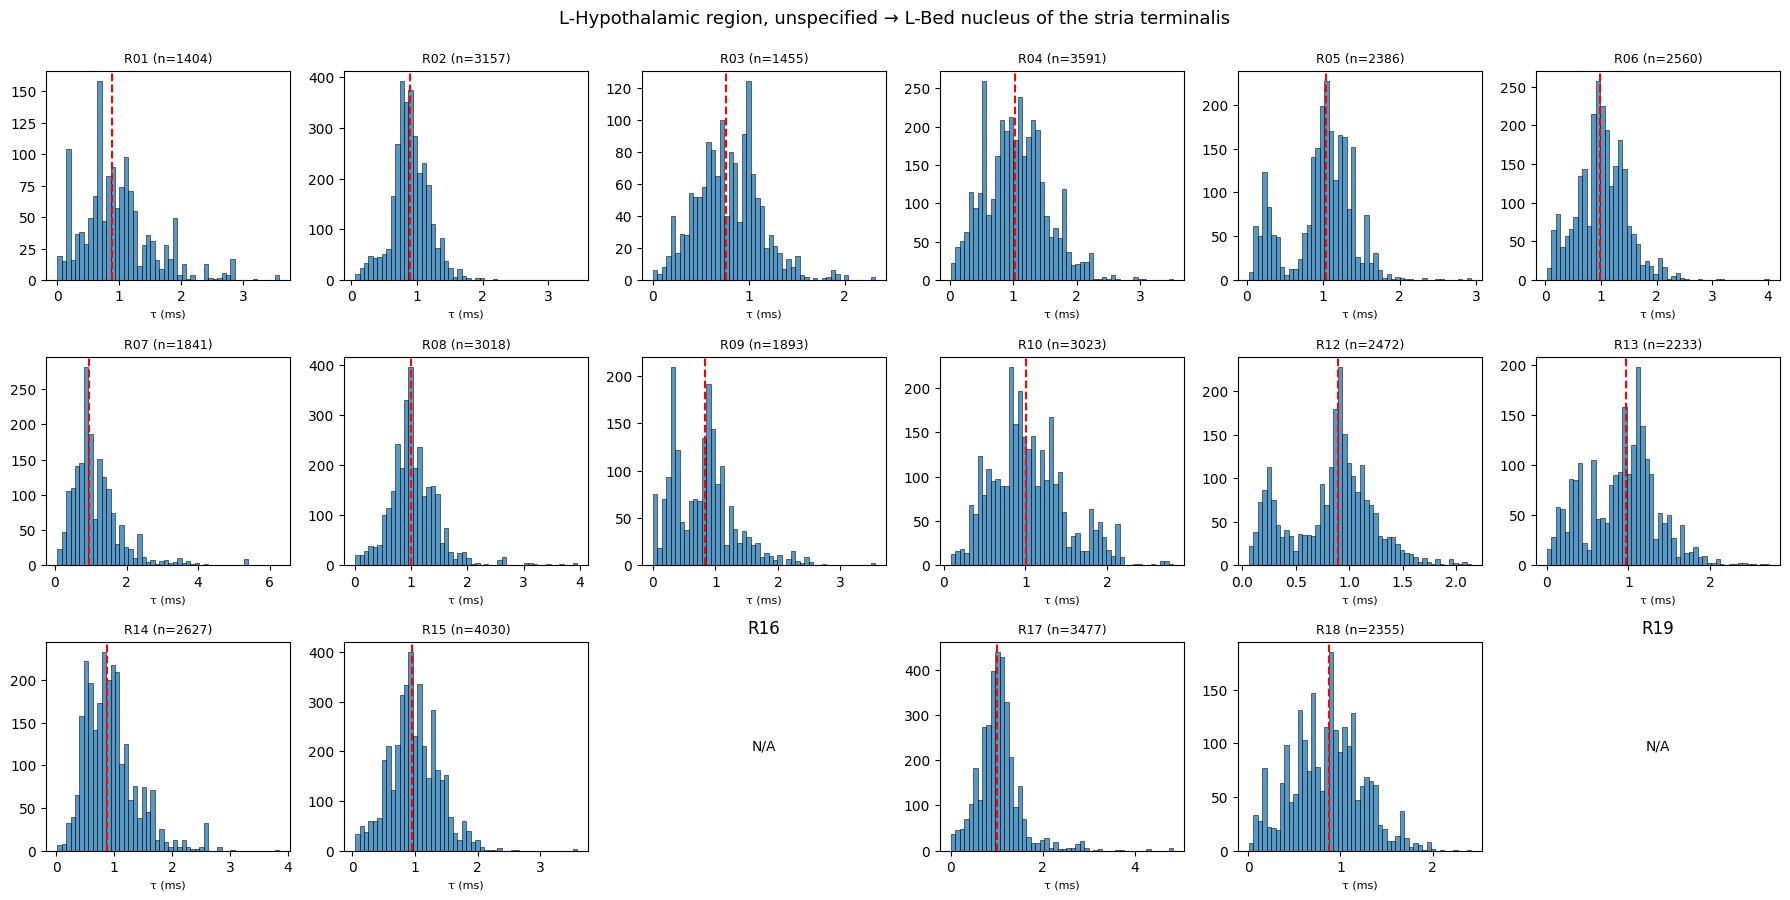

(np.int64(26), np.int64(58))


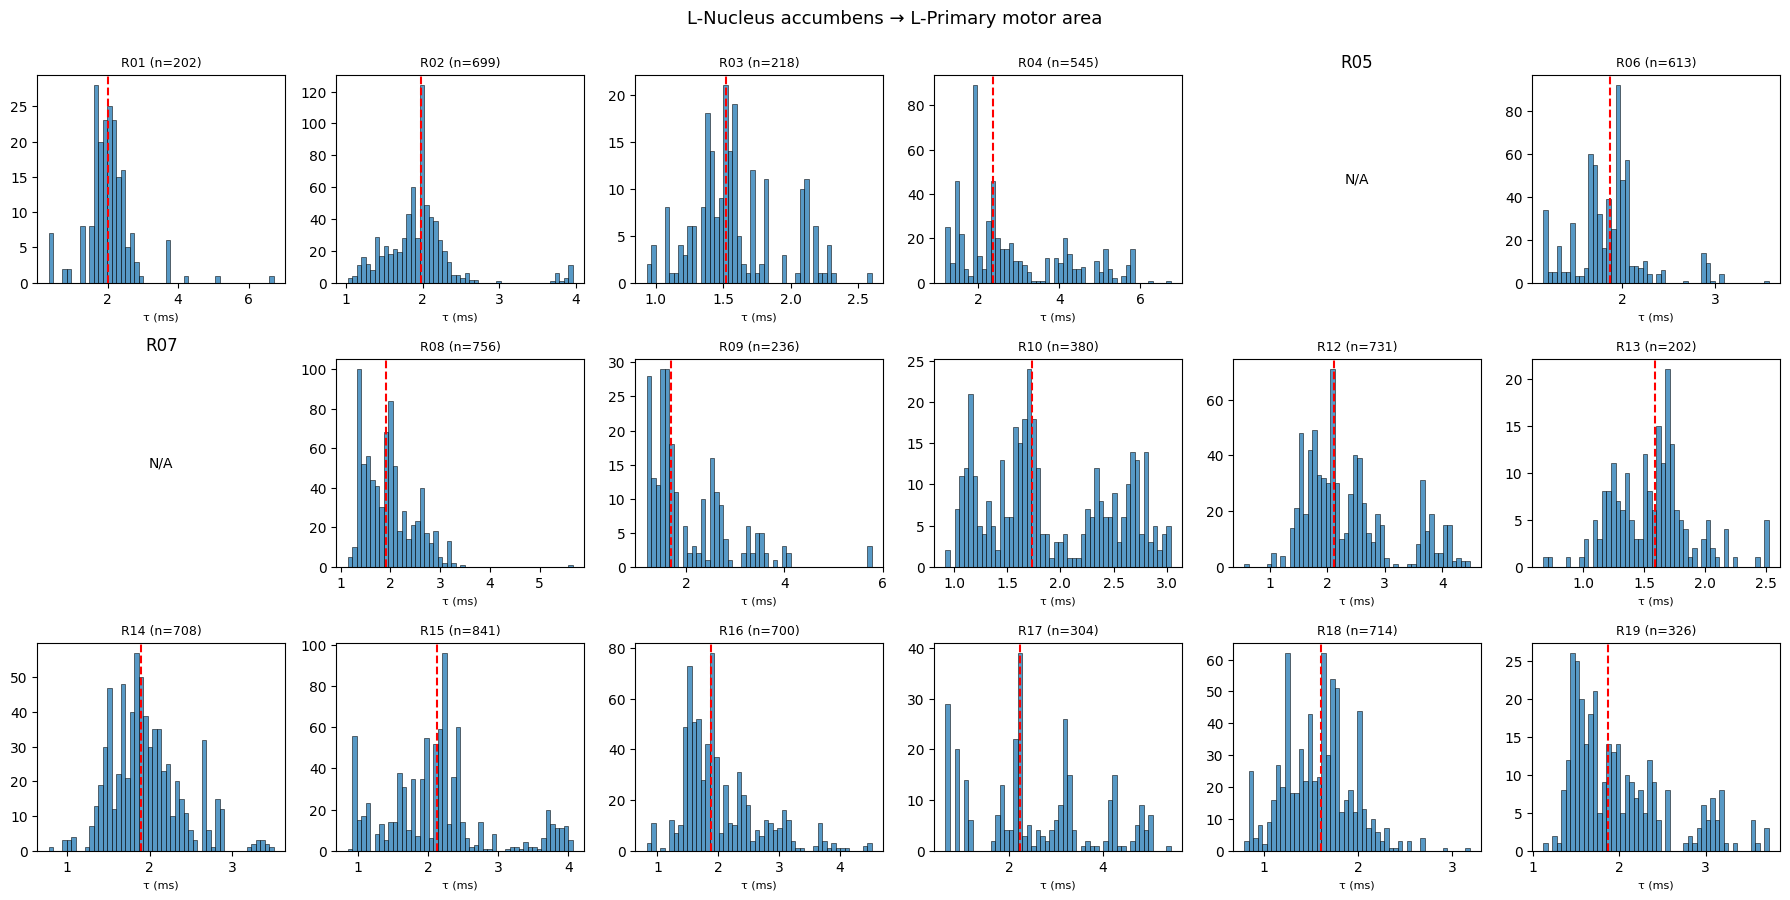

(np.int64(108), np.int64(132))


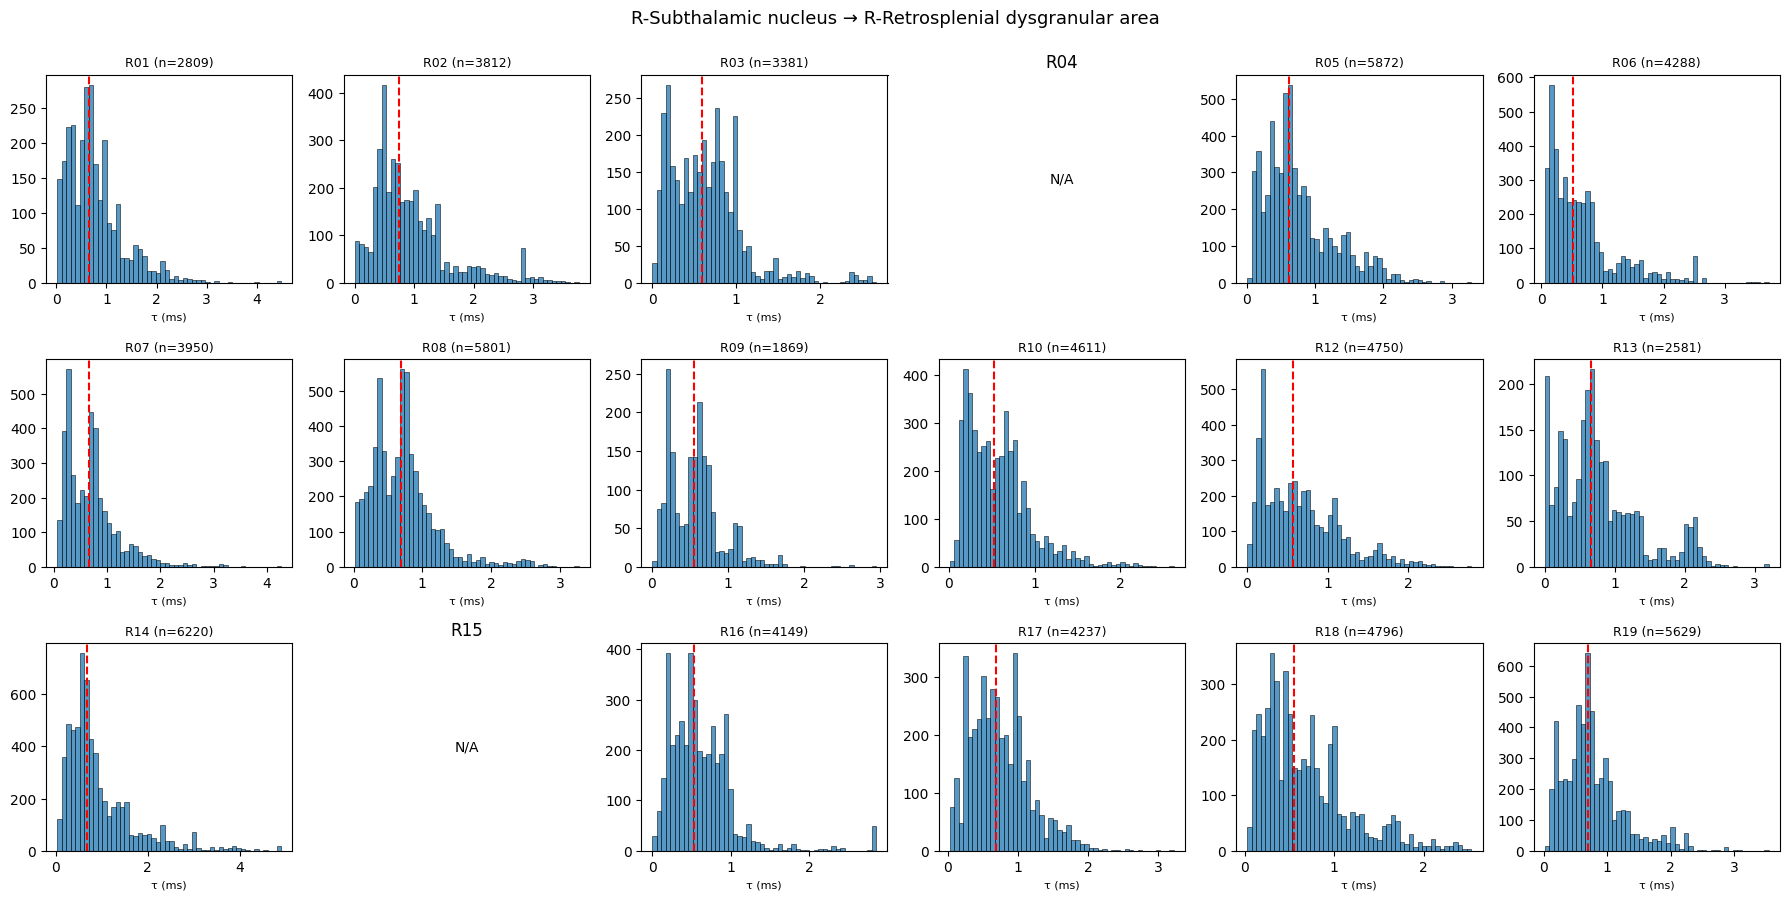

(np.int64(114), np.int64(121))


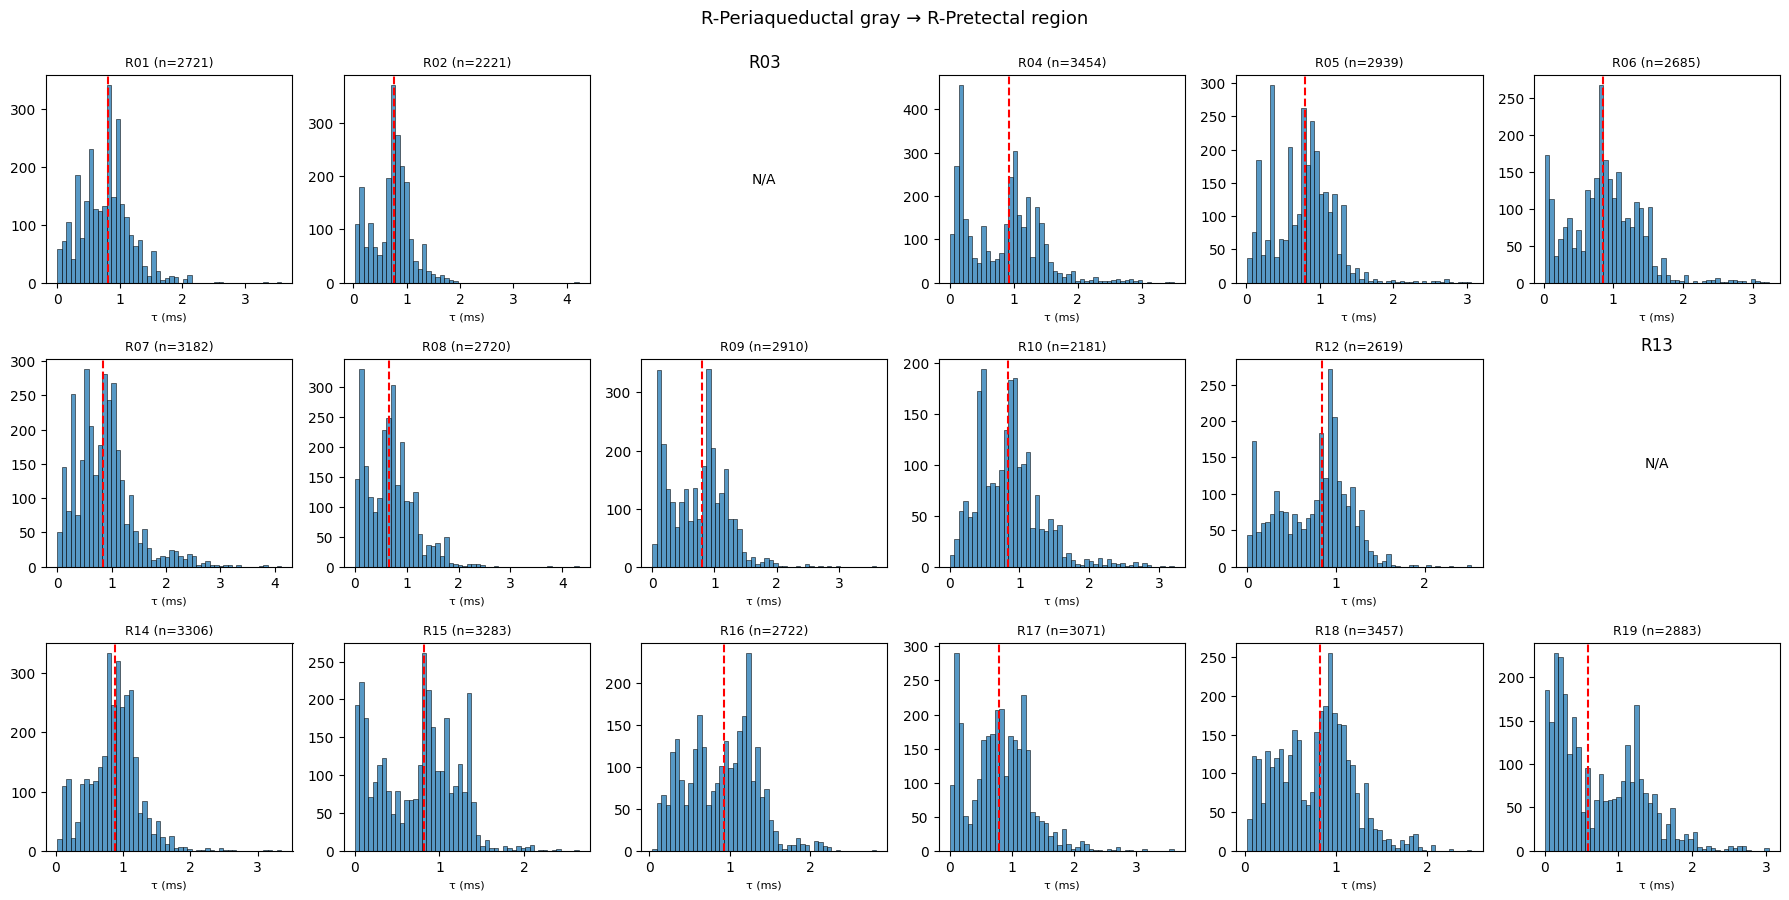

(np.int64(29), np.int64(58))


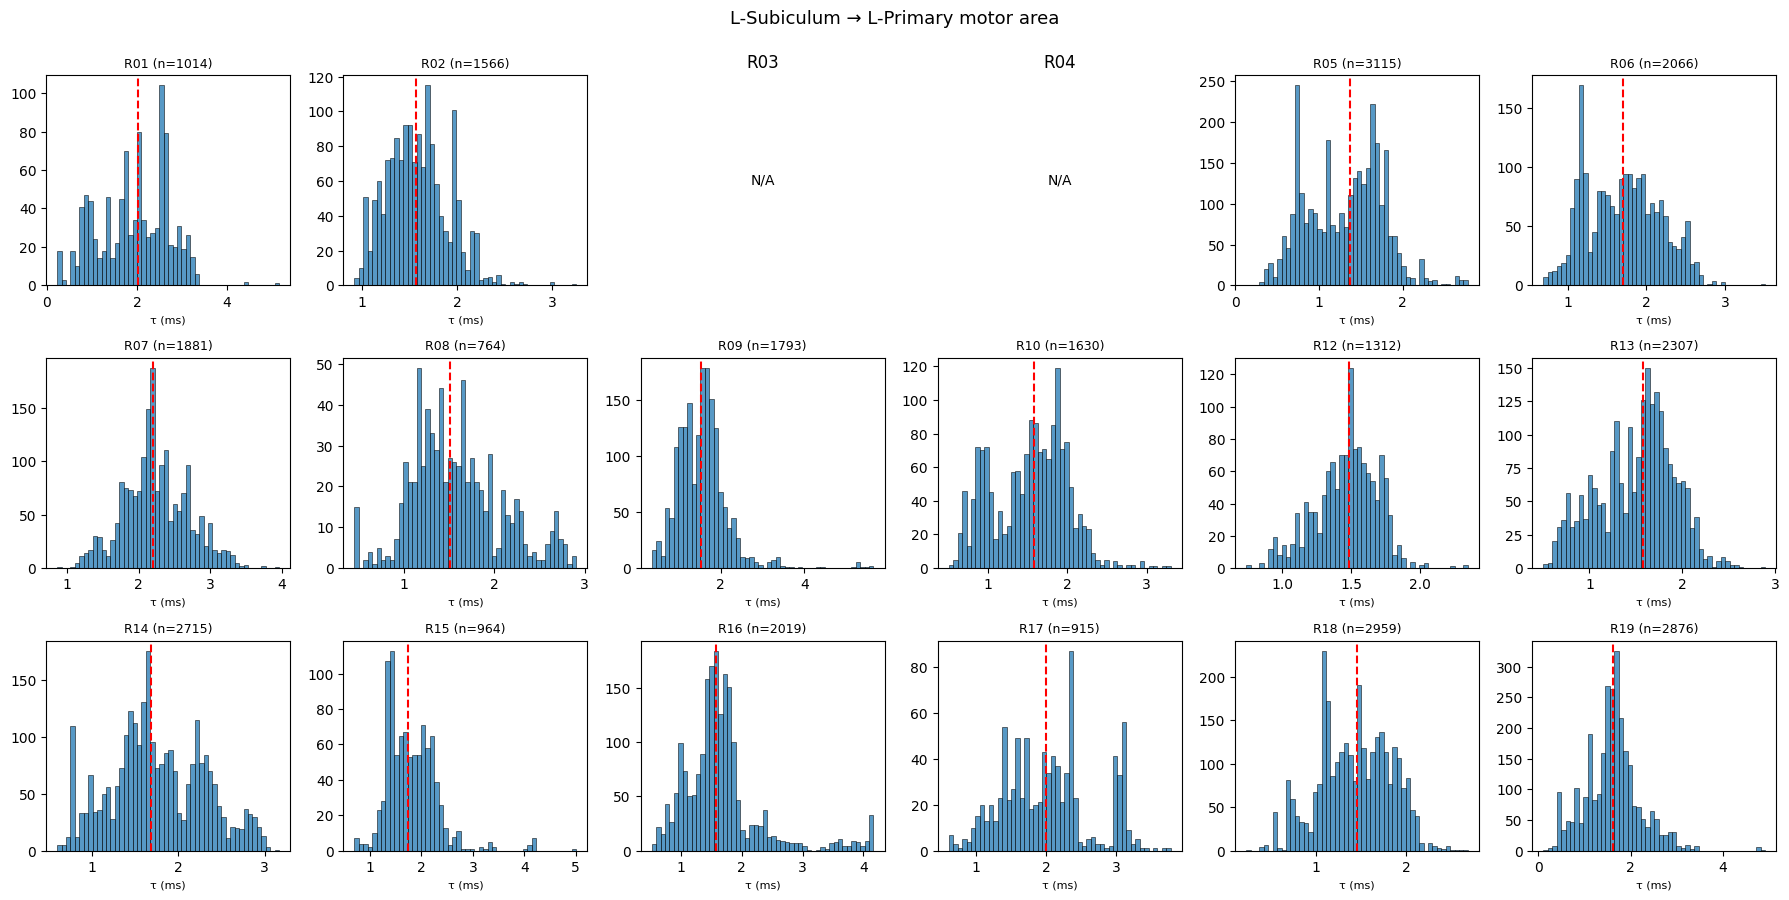

(np.int64(29), np.int64(53))


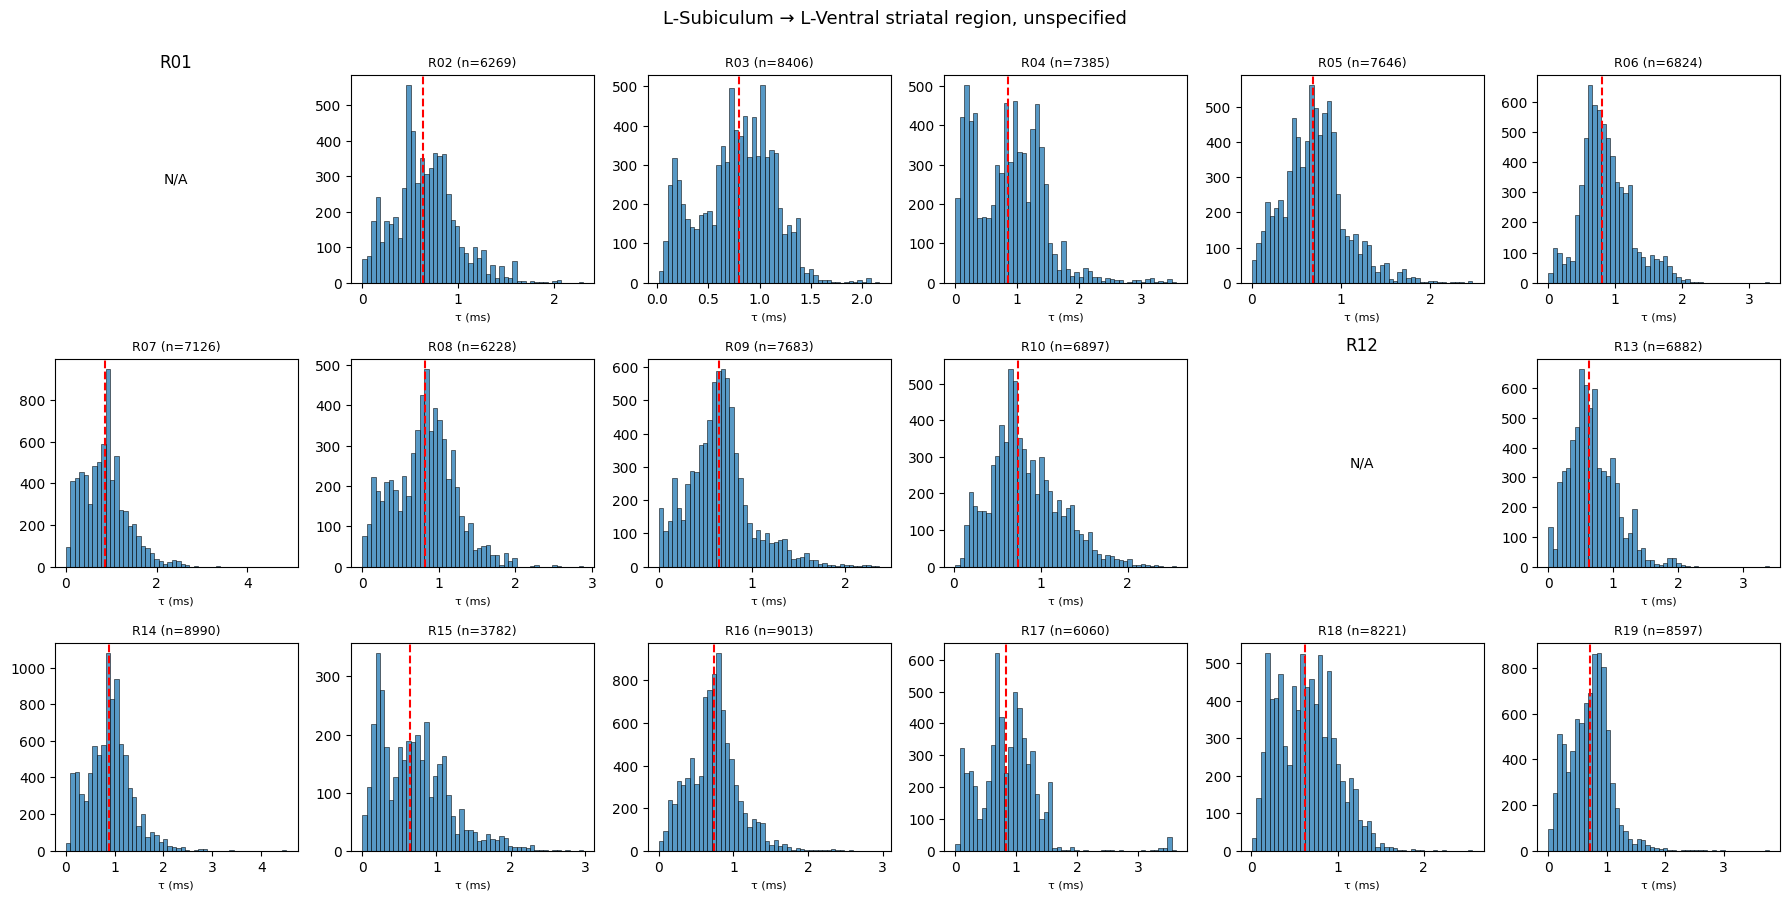

In [14]:
def plot_tau_distributions_multirat(rats_data, pair, name_map, bins=50):
    """Histogramas τ por rata (grid 3×6)"""
    fig, axes = plt.subplots(3, 6, figsize=(18, 9))
    axes = axes.ravel()
    
    for idx, (rat_id, data) in enumerate(sorted(rats_data.items())):
        if pair not in data:
            axes[idx].text(0.5, 0.5, 'N/A', ha='center', va='center')
            axes[idx].set_title(rat_id)
            axes[idx].axis('off')
            continue
        
        tau_ms = data[pair][:, COL_TAU] * 1e3
        axes[idx].hist(tau_ms, bins=bins, alpha=0.75, edgecolor='k', lw=0.5)
        axes[idx].axvline(np.median(tau_ms), color='r', ls='--', lw=1.5)
        axes[idx].set_title(f"{rat_id} (n={len(tau_ms)})", fontsize=9)
        axes[idx].set_xlabel('τ (ms)', fontsize=8)
    
    i, j = pair
    fig.suptitle(f"{roi_label(i, name_map)} → {roi_label(j, name_map)}", fontsize=13, y=0.995)
    plt.tight_layout()
    return fig

# Visualizar top 3
for idx in [0, 1, 2,3,4,5]:
    row = df_stable_diverse.iloc[idx]
    pair = (row['roi_i'], row['roi_j'])
    plot_tau_distributions_multirat(refined_rats, pair, name_map, bins=50)
    print(pair)
    plt.show()

In [16]:
# # ==============================================================
# # 🧩 EXPLORACIÓN MANUAL DE DISTRIBUCIONES — SELECCIÓN VISUAL
# # ==============================================================

# import matplotlib.pyplot as plt
# import pandas as pd

# # --------------------------------------------------------------
# # 1️⃣ Selección de conexiones candidatas
# # --------------------------------------------------------------

# # Filtramos las conexiones estables y ricas en fibras
# df_candidates = df_multi[
#     (df_multi['n_rats'] >= 4) &
#     (df_multi['cv_inter'] < 0.1) &
#     (df_multi['n_fibers_mean'] >= 50) &
#     (df_multi['tau_range_mean'] > 2.0)
# ].copy()

# # Ordenar por rango temporal y robustez
# df_candidates = df_candidates.sort_values(
#     ['tau_range_mean', 'n_fibers_mean'],
#     ascending=[False, False]
# ).reset_index(drop=True)

# print(f"✅ {len(df_candidates)} conexiones cumplen criterios")
# display(df_candidates.head(15)[[
#     'pair_label', 'tau_range_mean', 'cv_inter', 'n_fibers_mean',
#     'n_rats', 'hemi'
# ]])

# # --------------------------------------------------------------
# # 2️⃣ Visualización del top N
# # --------------------------------------------------------------

# def plot_multi_histogram(pair, cleaned_rats, name_map, bins=50):
#     """Visualiza distribuciones τ (ms) por rata en un grid."""
#     i, j = pair
#     fig, axes = plt.subplots(3, 6, figsize=(18, 9))
#     axes = axes.ravel()

#     for idx, (rat_id, data) in enumerate(sorted(cleaned_rats.items())):
#         ax = axes[idx]
#         if pair not in data:
#             ax.text(0.5, 0.5, 'N/A', ha='center', va='center')
#             ax.set_title(rat_id)
#             ax.axis('off')
#             continue

#         tau_ms = data[pair][:, COL_TAU] * 1e3
#         ax.hist(tau_ms, bins=bins, alpha=0.75, edgecolor='k', linewidth=0.5)
#         ax.axvline(np.median(tau_ms), color='r', ls='--', lw=1)
#         ax.set_title(f"{rat_id} (n={len(tau_ms)})", fontsize=8)
#         ax.set_xlabel('τ (ms)', fontsize=7)
#         ax.set_ylabel('freq', fontsize=7)

#     fig.suptitle(f"{roi_label(i, name_map)} → {roi_label(j, name_map)}", fontsize=13)
#     fig.tight_layout()
#     plt.show()

# # --------------------------------------------------------------
# # 3️⃣ Iterar visualmente sobre el top
# # --------------------------------------------------------------

# TOP_N = 10  # número de conexiones que quieres explorar

# for idx in range(TOP_N):
#     row = df_candidates.iloc[idx]
#     pair = (int(row.roi_i), int(row.roi_j))

#     print("="*80)
#     print(f"#{idx+1}  {row.pair_label}")
#     print(f"  τ_range_mean = {row.tau_range_mean:.2f} ms")
#     print(f"  n_fibers_mean = {row.n_fibers_mean:.0f}")
#     print(f"  n_rats = {row.n_rats}, CV_inter = {row.cv_inter:.2f}, hemi = {row.hemi}")
#     plot_multi_histogram(pair, cleaned_rats, name_map, bins=40)


In [16]:
df_stable_diverse['pair_label'].to_list()

['R-Subthalamic nucleus → R-Retrosplenial dysgranular area',
 'L-Parietal association cortex → L-Primary auditory area',
 'L-Hypothalamic region, unspecified → L-Bed nucleus of the stria terminalis',
 'R-Subthalamic nucleus → R-Retrosplenial granular area',
 'R-Subthalamic nucleus → R-Pretectal region',
 'L-Ventral striatal region, unspecified → L-Primary motor area',
 'L-Subiculum → L-Ventral striatal region, unspecified',
 'L-Olfactory bulb → L-Infralimbic area',
 'L-Medial entorhinal cortex → L-Retrosplenial granular area',
 'R-Cingulate area 2 → R-Retrosplenial dysgranular area',
 'R-Periaqueductal gray → R-Pretectal region',
 'R-Primary auditory area → R-Retrosplenial dysgranular area',
 'R-Zona incerta → R-Temporal association cortex',
 'L-Subiculum → L-Primary motor area',
 'R-Subthalamic nucleus → R-Dorsolateral orbital area',
 'L-Perirhinal area 35 → L-Endopiriform nucleus',
 'R-Perirhinal area 36 → R-Retrosplenial dysgranular area',
 'R-Globus pallidus external → R-Pretectal 

In [27]:
cleaned_rats['R01'][(29, 70)]

array([[2.8476422e-03, 8.4222518e-03, 2.9576228e+00, 2.5876563e+00,
        2.6241718e-02, 4.0311903e-01],
       [3.1923787e-03, 9.4418516e-03, 2.9576228e+00, 2.5876563e+00,
        2.6241718e-02, 4.0311903e-01],
       [1.8153170e-03, 7.6991851e-03, 4.2412343e+00, 2.6161170e+00,
        4.8364196e-02, 4.0311903e-01],
       ...,
       [2.4632153e-03, 7.1114516e-03, 2.8870606e+00, 2.3504856e+00,
        3.0539636e-02, 4.3730956e-01],
       [2.4983580e-03, 7.2129108e-03, 2.8870606e+00, 2.3504856e+00,
        3.6267951e-02, 3.5736579e-01],
       [2.5701621e-03, 7.4202139e-03, 2.8870606e+00, 2.3504856e+00,
        3.6267951e-02, 3.5736579e-01]], shape=(569, 6), dtype=float32)

In [31]:
roi_names[28], roi_names[69]    

('Hippocampus', 'Infralimbic area')

(29, 70)


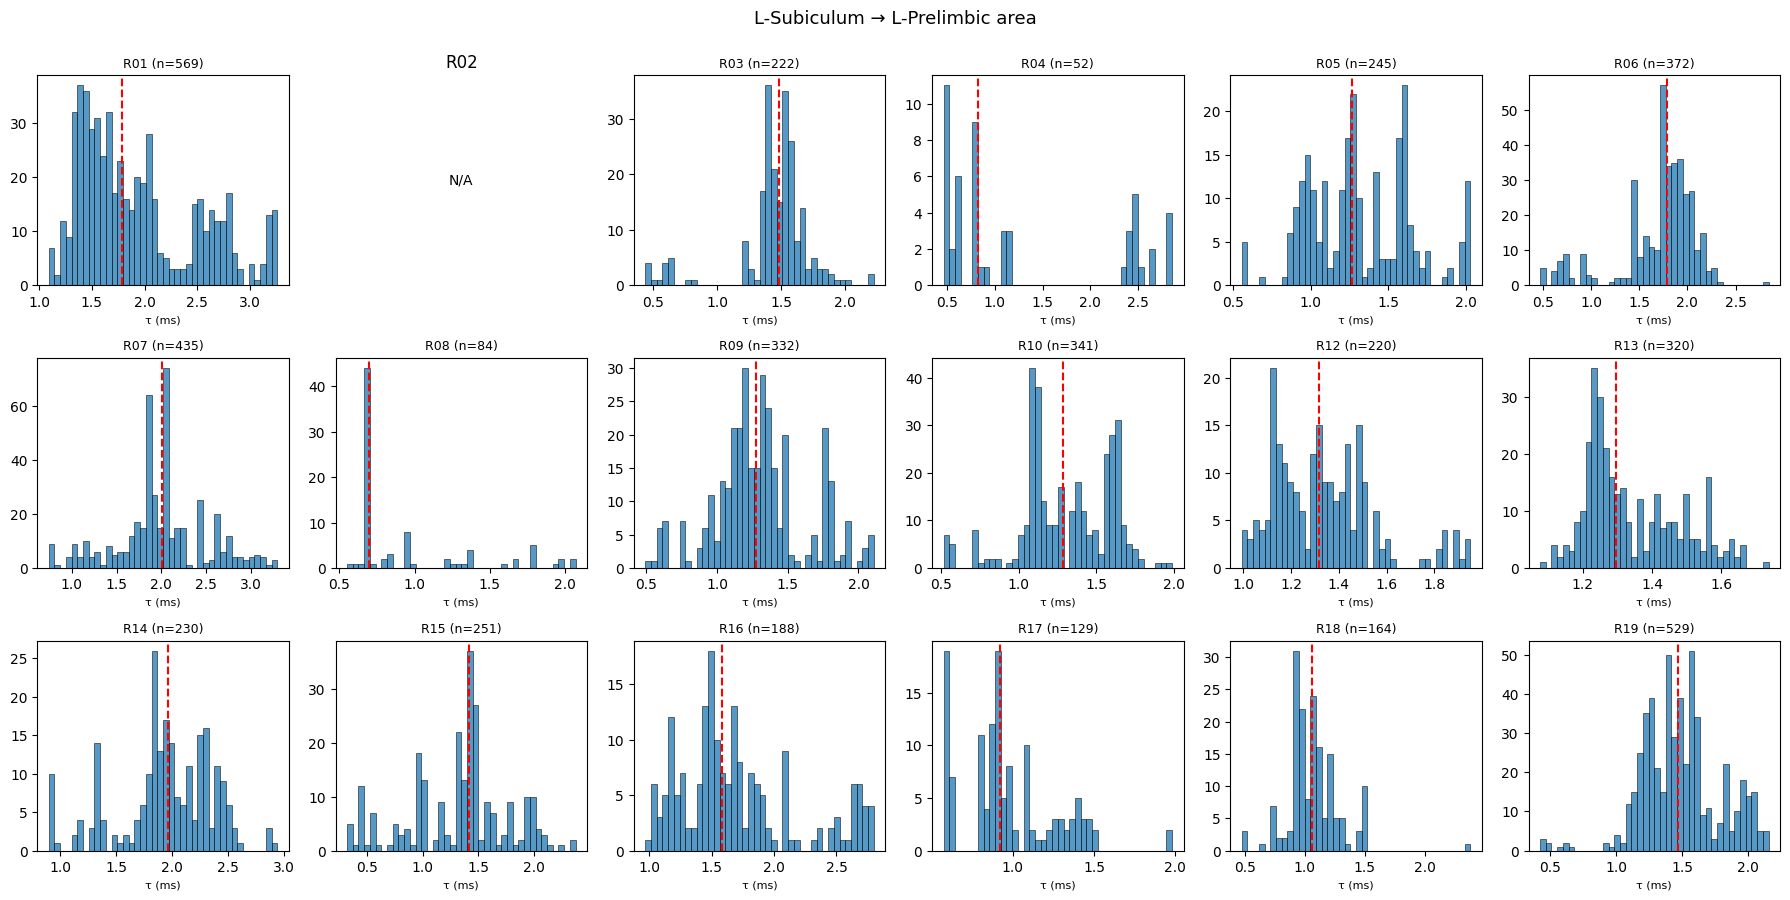

In [33]:
pair = (29, 70)
plot_tau_distributions_multirat(cleaned_rats, pair, name_map, bins=40)
print(pair)
plt.show()

In [ ]:
pair = (28, 69)
plot_avg_distribution(pair, refined_rats, name_map, 50, False)
print(pair)
print(label)
plt.show()

⚠️ Sin datos suficientes para L-Prelimbic area → L-Subiculum
(70, 29)
R-Periaqueductal gray → R-Infralimbic area


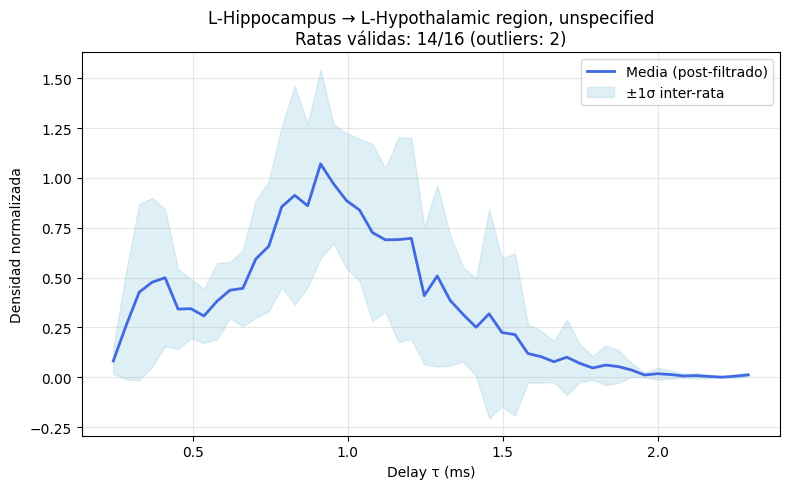

(np.int64(28), np.int64(35))
L-Hippocampus → L-Hypothalamic region, unspecified


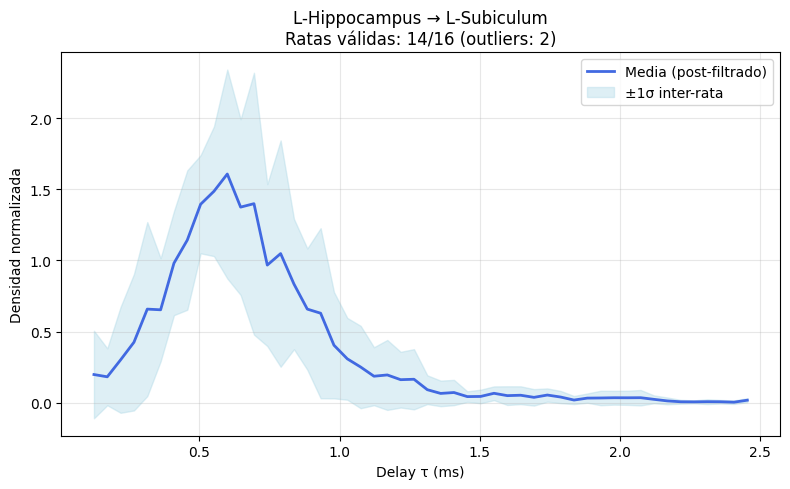

(np.int64(28), np.int64(29))
L-Hippocampus → L-Subiculum


In [17]:
# ==============================================================
# 🧩 DISTRIBUCIONES PROMEDIADAS MULTI-RATA + DESCARTE OUTLIERS (±3σ)
# ==============================================================

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def plot_avg_distribution(pair, cleaned_rats, name_map, bins=75, save=False, sigma_thresh=1.0):
    """
    Calcula y muestra el histograma promedio multi-rata con exclusión de outliers (>3σ).
    Devuelve (centers, mean_hist, kept_rats)
    """
    i, j = pair
    all_hists, all_edges, valid_rats = [], [], []

    # --- Calcular histogramas individuales normalizados ---
    for rat_id, data in cleaned_rats.items():
        if pair not in data:
            continue
        tau_ms = data[pair][:, COL_TAU] * 1e3
        hist, edges = np.histogram(tau_ms, bins=bins, density=True)
        all_hists.append(hist)
        all_edges.append(edges)
        valid_rats.append(rat_id)

    if not all_hists:
        print(f"⚠️ Sin datos suficientes para {roi_label(i, name_map)} → {roi_label(j, name_map)}")
        return None, None, []

    # --- Verificar consistencia de bins ---
    edges = all_edges[0]
    all_hists = np.array([h for h in all_hists if len(h) == len(edges) - 1])

    # --- Calcular media y desviación inicial ---
    mean_init = all_hists.mean(axis=0)
    std_init = all_hists.std(axis=0)

    # --- Evaluar distancia tipo z-score promedio por rata ---
    z_scores = []
    for h in all_hists:
        z = np.abs(h - mean_init) / (std_init + 1e-8)
        z_mean = np.nanmean(z)
        z_scores.append(z_mean)
    z_scores = np.array(z_scores)

    # --- Filtrar ratas dentro de umbral (3σ) ---
    keep_mask = z_scores < sigma_thresh
    kept_hists = all_hists[keep_mask]
    kept_rats = np.array(valid_rats)[keep_mask]

    # --- Recalcular promedio y desviación final ---
    mean_hist = kept_hists.mean(axis=0)
    std_hist = kept_hists.std(axis=0)
    centers = (edges[:-1] + edges[1:]) / 2

    # --- Plot ---
    plt.figure(figsize=(8, 5))
    plt.plot(centers, mean_hist, color='royalblue', lw=2, label='Media (post-filtrado)')
    plt.fill_between(centers, mean_hist - std_hist, mean_hist + std_hist,
                     color='lightblue', alpha=0.4, label='±1σ inter-rata')
    plt.xlabel('Delay τ (ms)')
    plt.ylabel('Densidad normalizada')
    plt.title(f"{roi_label(i, name_map)} → {roi_label(j, name_map)}\n"
              f"Ratas válidas: {len(kept_rats)}/{len(valid_rats)} (outliers: {len(valid_rats)-len(kept_rats)})")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- Exportar opcionalmente los valores promedio ---
    if save:
        export_dir = Path('./data/exports/avg_distributions_filtered')
        export_dir.mkdir(parents=True, exist_ok=True)
        np.savez(
            export_dir / f"avgdist_{roi_label(i, name_map)}_to_{roi_label(j, name_map)}.npz",
            centers=centers,
            mean_hist=mean_hist,
            std_hist=std_hist,
            kept_rats=kept_rats
        )
        print(f"✅ Exportado promedio multi-rata (filtrado 3σ): "
              f"{roi_label(i, name_map)} → {roi_label(j, name_map)}")

    return centers, mean_hist, kept_rats


for idx in range(len(df_stable_diverse)):
    
    label = df_stable_diverse.iloc[idx]['pair_label']
    
    if "Hippo" in label:

        row = df_stable_diverse.iloc[idx]
        pair = (row['roi_i'], row['roi_j'])
        plot_avg_distribution(pair, refined_rats, name_map, 50, False)
        print(pair)
        print(label)
        plt.show()


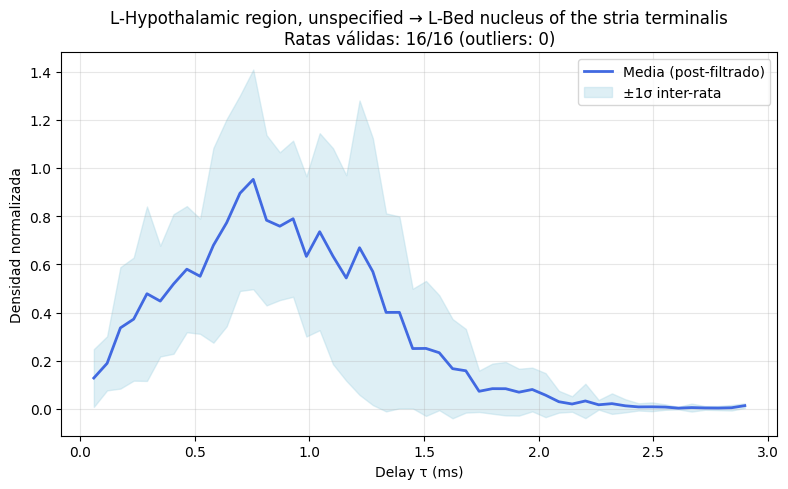

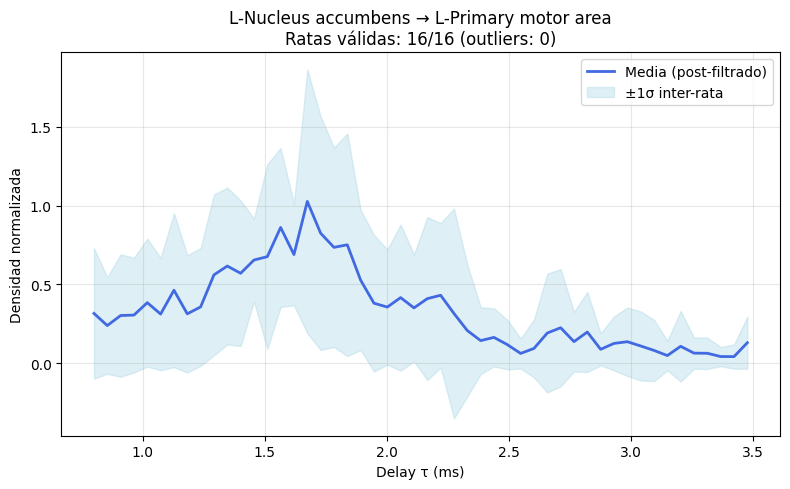

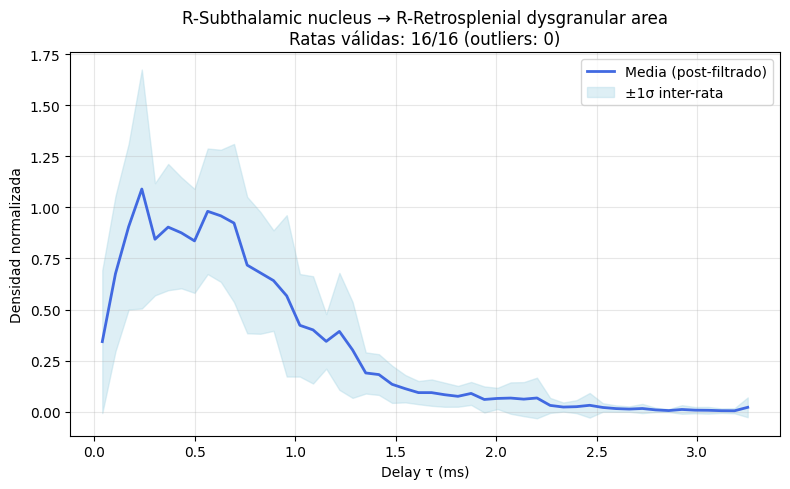

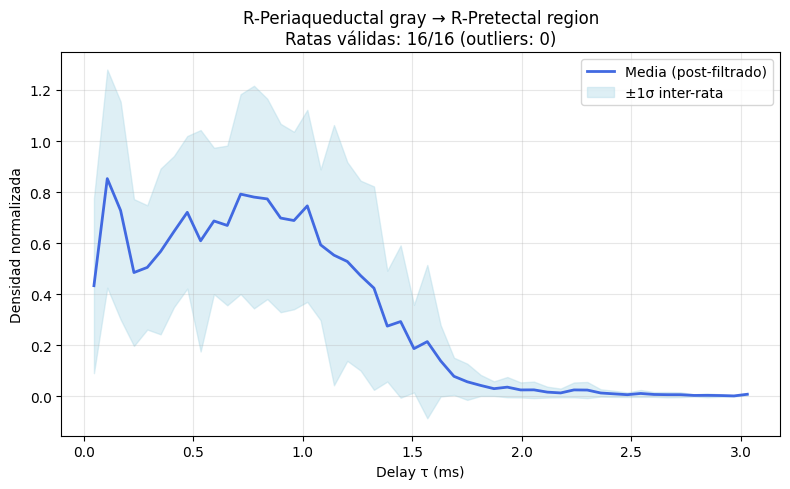

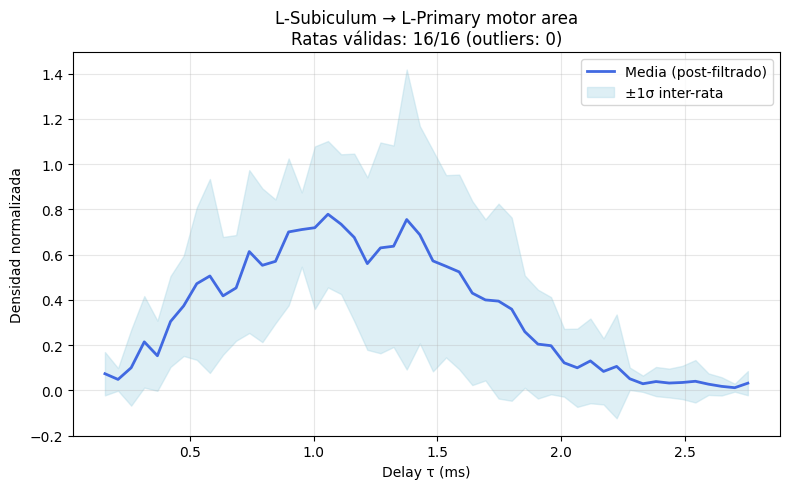


🔍 ANÁLISIS DE FORMAS DE DISTRIBUCIÓN (Top 15)


,pair_label,n_modes,tau_peak_ms,tau_weighted_mean_ms,skewness,n_rats_kept,n_rats_total,outliers
0,"L-Hypothalamic region, unspecified → L-Bed nuc...",4,0.754838,0.889388,0.159726,16,16,0
1,L-Nucleus accumbens → L-Primary motor area,4,1.675274,1.768985,0.185965,16,16,0
2,R-Subthalamic nucleus → R-Retrosplenial dysgra...,3,0.237427,0.712806,0.363062,16,16,0
3,R-Periaqueductal gray → R-Pretectal region,4,0.106334,0.770091,0.151293,16,16,0
4,L-Subiculum → L-Primary motor area,3,1.058125,1.175448,0.082451,16,16,0



📊 CLASIFICACIÓN POR MODALIDAD:
n_modes
3    2
4    3
dtype: int64

📈 BIMODALES (n_modes ≥ 2):


,pair_label,tau_peak_ms,skewness
0,"L-Hypothalamic region, unspecified → L-Bed nuc...",0.754838,0.159726
1,L-Nucleus accumbens → L-Primary motor area,1.675274,0.185965
2,R-Subthalamic nucleus → R-Retrosplenial dysgra...,0.237427,0.363062
3,R-Periaqueductal gray → R-Pretectal region,0.106334,0.151293
4,L-Subiculum → L-Primary motor area,1.058125,0.082451



⚖️ SIMETRÍA (skewness cerca de 0 = gaussiana, >1 = cola derecha larga):


,pair_label,skewness,n_modes
4,L-Subiculum → L-Primary motor area,0.082451,3
3,R-Periaqueductal gray → R-Pretectal region,0.151293,4
0,"L-Hypothalamic region, unspecified → L-Bed nuc...",0.159726,4
1,L-Nucleus accumbens → L-Primary motor area,0.185965,4
2,R-Subthalamic nucleus → R-Retrosplenial dysgra...,0.363062,3


In [28]:
# Análisis sistemático de las 15 top conexiones
results = []

for idx in range(min(5, len(df_stable_diverse))):
    row = df_stable_diverse.iloc[idx]
    pair = (row['roi_i'], row['roi_j'])
    
    centers, mean_hist, kept_rats = plot_avg_distribution(
        pair, refined_rats, name_map, bins=50, save=False, sigma_thresh=3.0
    )
    
    if centers is not None and len(centers) > 0:
        # Detectar modalidad
        from scipy.signal import find_peaks
        peaks, _ = find_peaks(mean_hist, height=mean_hist.max()*0.3, distance=5)
        n_modes = len(peaks)
        
        # Estadísticas
        tau_mean = np.average(centers, weights=mean_hist)
        tau_median = centers[np.argmax(mean_hist)]
        skewness = ((centers - tau_mean)**3 * mean_hist).sum() / (((centers - tau_mean)**2 * mean_hist).sum())**1.5
        
        results.append({
            'pair_label': row['pair_label'],
            'n_modes': n_modes,
            'tau_peak_ms': tau_median,
            'tau_weighted_mean_ms': tau_mean,
            'skewness': skewness,
            'n_rats_kept': len(kept_rats),
            'n_rats_total': row['n_rats'],
            'outliers': row['n_rats'] - len(kept_rats)
        })

df_shapes = pd.DataFrame(results)
print("\n🔍 ANÁLISIS DE FORMAS DE DISTRIBUCIÓN (Top 15)")
print("="*80)
display(df_shapes)

# Clasificación por modalidad
print("\n📊 CLASIFICACIÓN POR MODALIDAD:")
print(df_shapes.groupby('n_modes').size())

print("\n📈 BIMODALES (n_modes ≥ 2):")
display(df_shapes[df_shapes['n_modes'] >= 2][['pair_label', 'tau_peak_ms', 'skewness']])

print("\n⚖️ SIMETRÍA (skewness cerca de 0 = gaussiana, >1 = cola derecha larga):")
display(df_shapes[['pair_label', 'skewness', 'n_modes']].sort_values('skewness'))

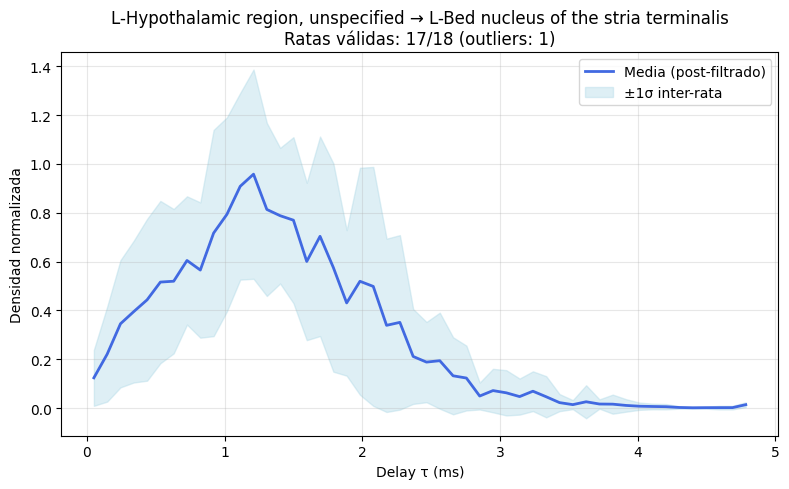

(np.int64(35), np.int64(42))
L-Hypothalamic region, unspecified → L-Bed nucleus of the stria terminalis


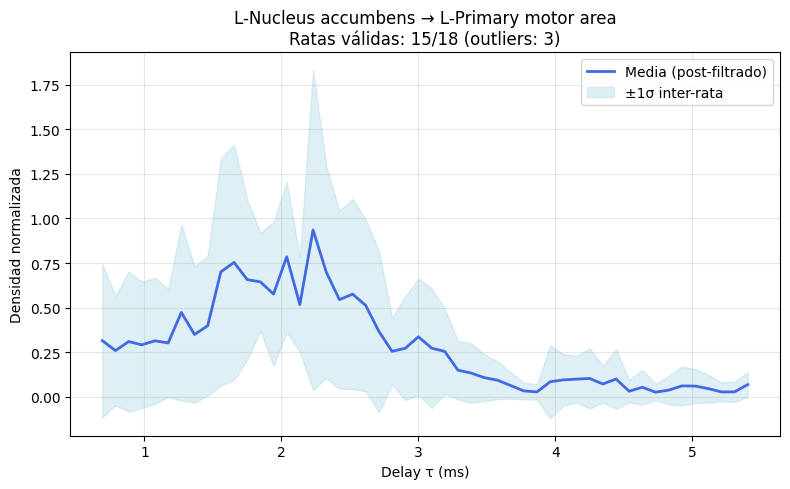

(np.int64(26), np.int64(58))
L-Nucleus accumbens → L-Primary motor area


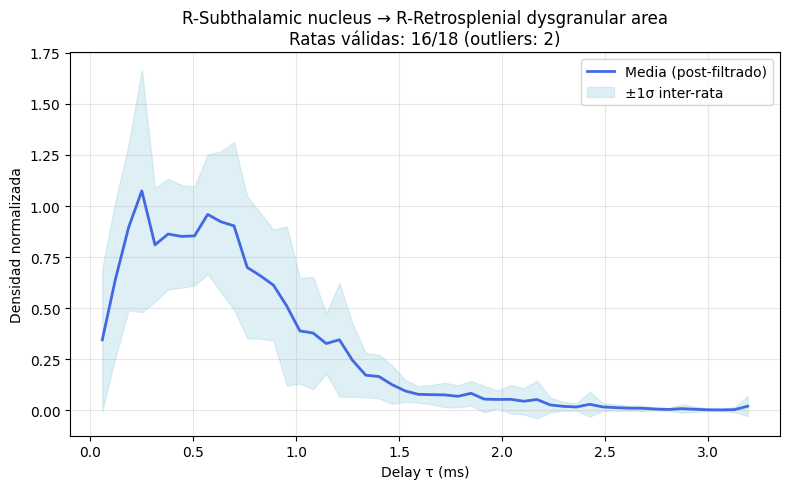

(np.int64(108), np.int64(132))
R-Subthalamic nucleus → R-Retrosplenial dysgranular area


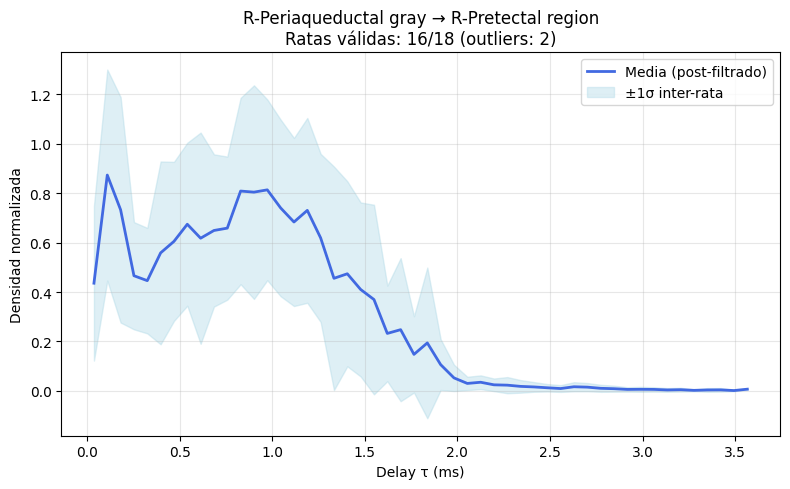

(np.int64(114), np.int64(121))
R-Periaqueductal gray → R-Pretectal region


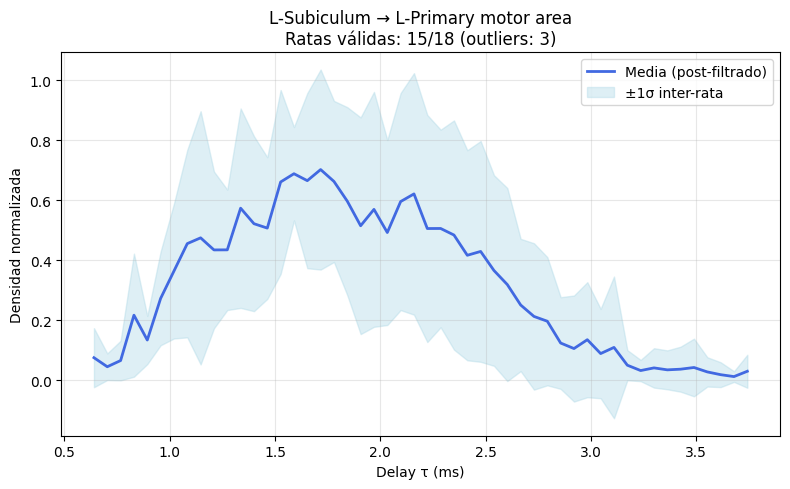

(np.int64(29), np.int64(58))
L-Subiculum → L-Primary motor area


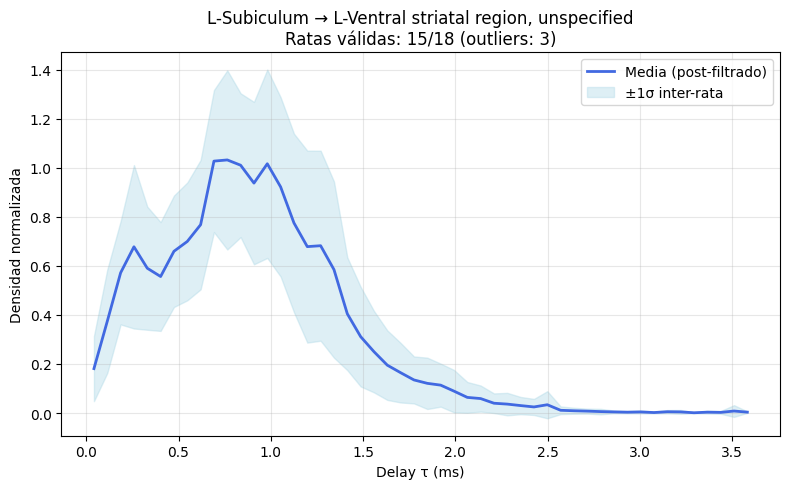

(np.int64(29), np.int64(53))
L-Subiculum → L-Ventral striatal region, unspecified


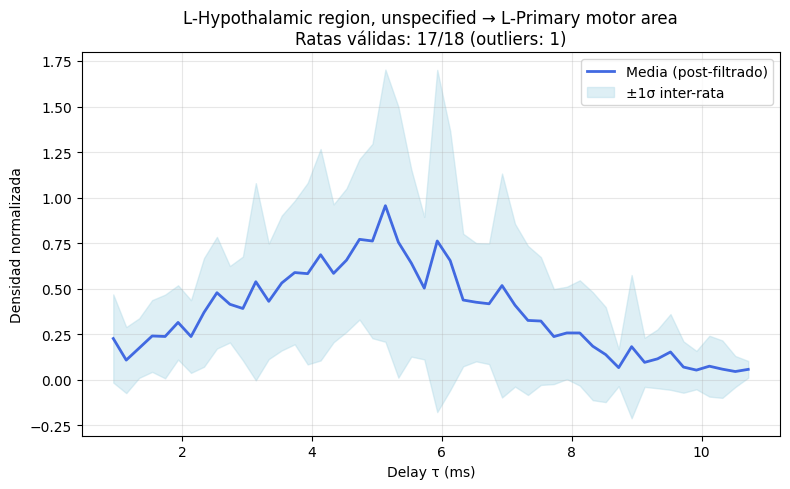

(np.int64(35), np.int64(58))
L-Hypothalamic region, unspecified → L-Primary motor area


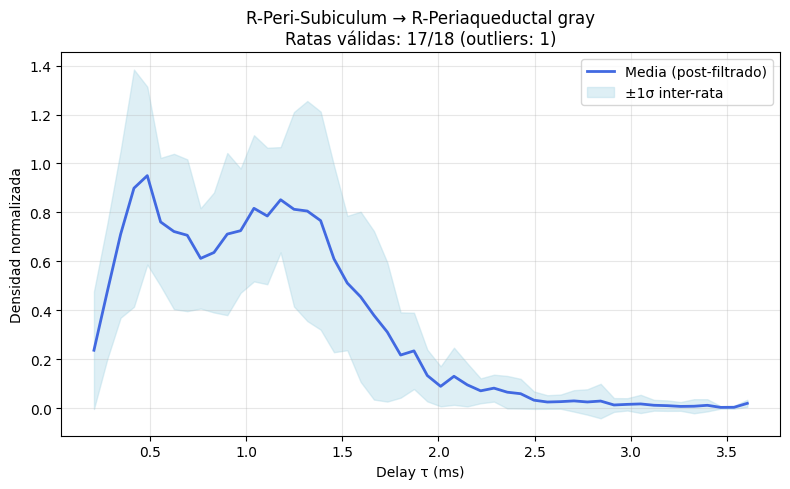

(np.int64(103), np.int64(114))
R-Peri-Subiculum → R-Periaqueductal gray


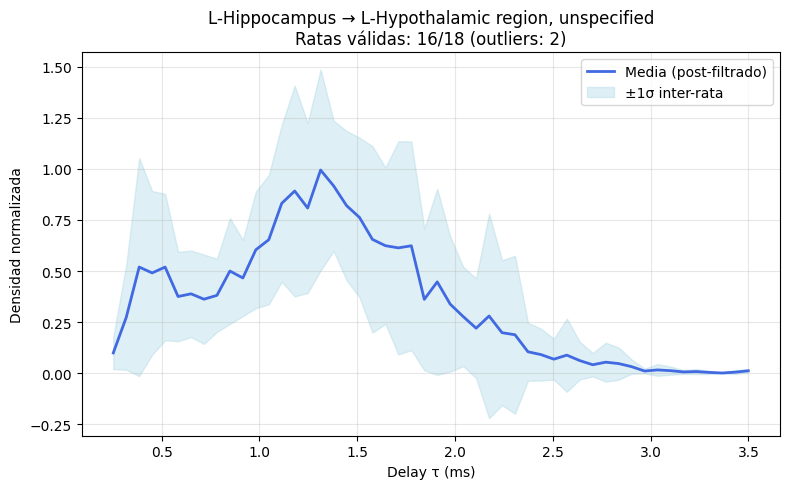

(np.int64(28), np.int64(35))
L-Hippocampus → L-Hypothalamic region, unspecified


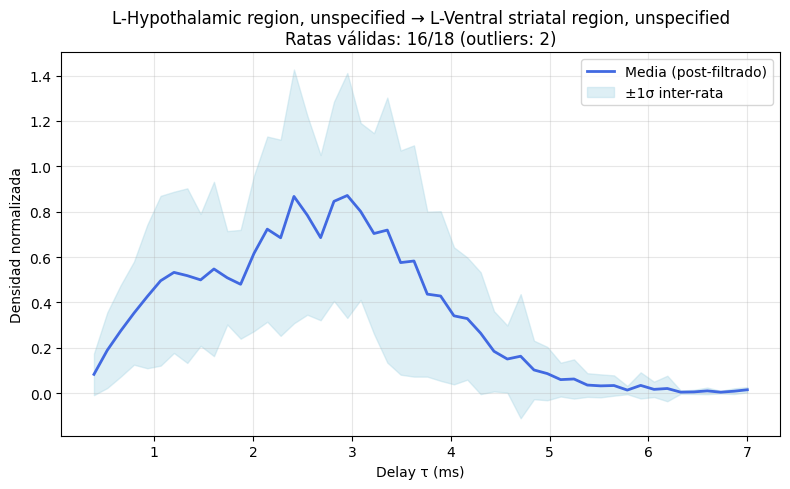

(np.int64(35), np.int64(53))
L-Hypothalamic region, unspecified → L-Ventral striatal region, unspecified


In [26]:
for idx in range(10):
    
    
    row = df_stable_diverse.iloc[idx]
    pair = (row['roi_i'], row['roi_j'])
    plot_avg_distribution(pair, cleaned_rats, name_map, 50, False)
    print(pair)
    print(df_stable_diverse.iloc[idx]['pair_label'])
    # plt.show()

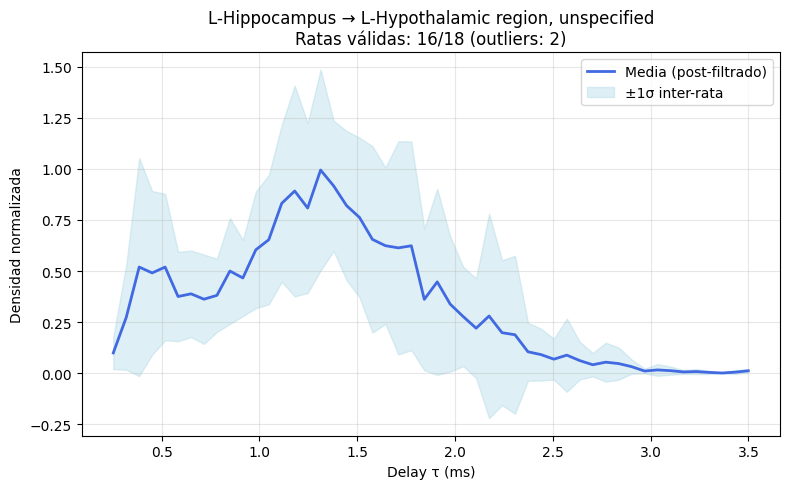

✅ Exportado promedio multi-rata (filtrado 3σ): L-Hippocampus → L-Hypothalamic region, unspecified


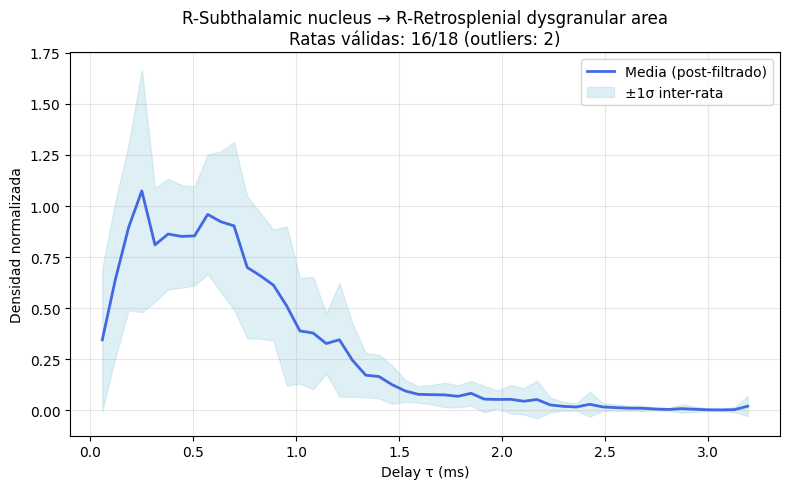

✅ Exportado promedio multi-rata (filtrado 3σ): R-Subthalamic nucleus → R-Retrosplenial dysgranular area


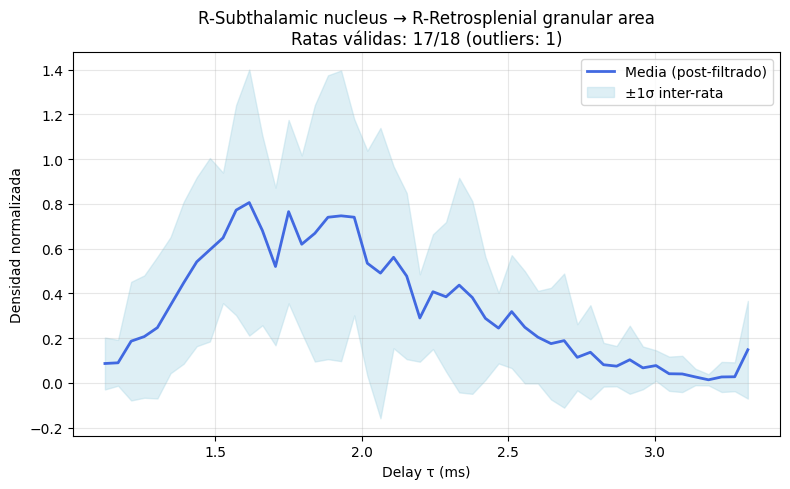

✅ Exportado promedio multi-rata (filtrado 3σ): R-Subthalamic nucleus → R-Retrosplenial granular area


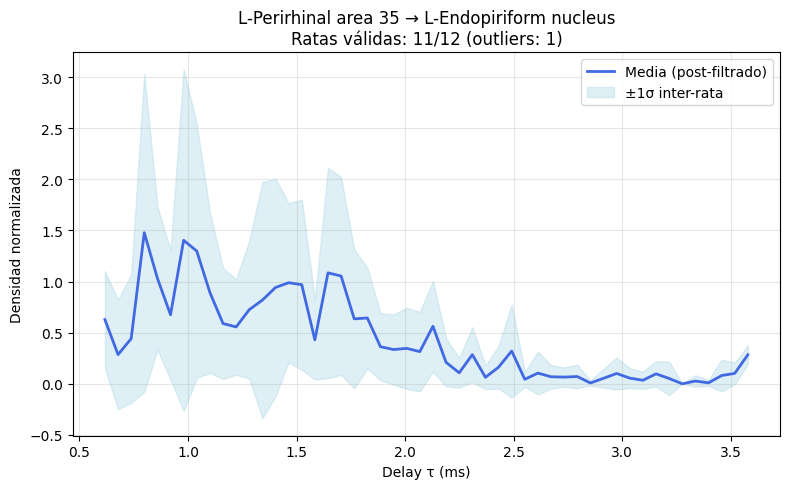

✅ Exportado promedio multi-rata (filtrado 3σ): L-Perirhinal area 35 → L-Endopiriform nucleus


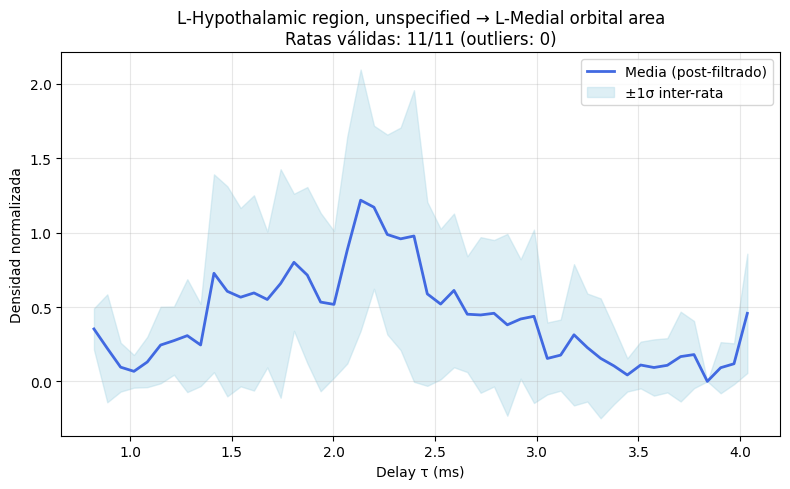

✅ Exportado promedio multi-rata (filtrado 3σ): L-Hypothalamic region, unspecified → L-Medial orbital area

✅ Exportación completa:


,label,n_rats_valid,file
0,"L-Hippocampus → L-Hypothalamic region, unspeci...",16,avgdist_L-Hippocampus_to_L-Hypothalamic region...
1,R-Subthalamic nucleus → R-Retrosplenial dysgra...,16,avgdist_R-Subthalamic nucleus_to_R-Retrospleni...
2,R-Subthalamic nucleus → R-Retrosplenial granul...,17,avgdist_R-Subthalamic nucleus_to_R-Retrospleni...
3,L-Perirhinal area 35 → L-Endopiriform nucleus,11,avgdist_L-Perirhinal area 35_to_L-Endopiriform...
4,"L-Hypothalamic region, unspecified → L-Medial ...",11,"avgdist_L-Hypothalamic region, unspecified_to_..."


In [29]:
# ==============================================================
# 🧩 DISTRIBUCIONES PROMEDIADAS FINALES (filtrado ±3σ)
# ==============================================================

selected_pairs = [
    (np.int64(28), np.int64(35)),   # L-Hippocampus → L-Hypothalamic region
    (np.int64(108), np.int64(132)), # R-Subthalamic nucleus → R-Retrosplenial dysgranular area
    (np.int64(108), np.int64(137)), # R-Subthalamic nucleus → R-Retrosplenial granular area
    (np.int64(45), np.int64(61)),   # L-Perirhinal area 35 → L-Endopiriform nucleus
    (np.int64(35), np.int64(76))    # L-Hypothalamic region → L-Medial orbital area
]

export_dir = Path('./results/data_analysis/distros/final_avg_distributions_manual')
export_dir.mkdir(parents=True, exist_ok=True)

summary_records = []

for pair in selected_pairs:
    centers, mean_hist, kept_rats = plot_avg_distribution(
        pair, cleaned_rats, name_map, bins=50, save=True
    )

    if centers is None:
        continue

    label = f"{roi_label(pair[0], name_map)} → {roi_label(pair[1], name_map)}"
    summary_records.append({
        'pair': pair,
        'label': label,
        'n_rats_valid': len(kept_rats),
        'kept_rats': ','.join(kept_rats),
        'file': f"avgdist_{roi_label(pair[0], name_map)}_to_{roi_label(pair[1], name_map)}.npz"
    })

# Crear resumen tabular
df_summary = pd.DataFrame(summary_records)
df_summary.to_csv(export_dir / 'summary_avg_distributions.csv', index=False)

print("\n✅ Exportación completa:")
display(df_summary[['label', 'n_rats_valid', 'file']])


In [30]:
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy import stats

def characterize_distributions_enhanced(cleaned_rats, pairs_list):
    """Features + divergencias vs referencia"""
    rows = []
    
    # 1er paso: construir distribución de referencia (pooled)
    all_tau = []
    for rat_id, data in cleaned_rats.items():
        for (i, j) in pairs_list:
            if (i, j) in data:
                all_tau.append(data[(i,j)][:, COL_TAU] * 1e3)
    ref_tau = np.concatenate(all_tau)
    ref_hist, ref_edges = np.histogram(ref_tau, bins=50, density=True)
    ref_cdf = np.cumsum(ref_hist) / ref_hist.sum()
    
    # 2do paso: caracterizar cada distribución
    for rat_id, data in cleaned_rats.items():
        for (i, j) in pairs_list:
            if (i, j) not in data:
                continue
            
            tau_ms = data[(i,j)][:, COL_TAU] * 1e3
            
            # Histogram
            hist, edges = np.histogram(tau_ms, bins='auto', density=True)
            peaks, _ = find_peaks(hist, prominence=hist.max()*0.1)
            
            # Métricas de forma
            g1 = stats.skew(tau_ms)
            g2 = stats.kurtosis(tau_ms, fisher=True)
            bimodality_coef = (g1**2 + 1) / (g2 + 3)
            
            hist_prob = hist / hist.sum()
            shannon_entropy = entropy(hist_prob[hist_prob > 0])
            
            # Robustez
            med = np.median(tau_ms)
            mad = np.median(np.abs(tau_ms - med))
            cv_robust = 1.4826 * mad / med if med > 0 else np.nan
            
            # Divergencias vs referencia
            wassers_dist = wasserstein_distance(tau_ms, ref_tau)
            ks_stat, _ = stats.ks_2samp(tau_ms, ref_tau)
            
            # KL divergence (discretizada, evita log(0))
            hist_sample, _ = np.histogram(tau_ms, bins=ref_edges, density=True)
            hist_sample = hist_sample / hist_sample.sum()
            # Añadir epsilon para evitar log(0)
            eps = 1e-10
            kl_div = entropy(hist_sample + eps, ref_hist + eps)
            
            rows.append({
                'rat_id': rat_id, 'roi_i': i, 'roi_j': j,
                'pair_label': f"{roi_label(i, name_map)} → {roi_label(j, name_map)}",
                'n': len(tau_ms),
                'mean': tau_ms.mean(),
                'median': med,
                'cv_robust': cv_robust,
                'skew': g1,
                'kurt': g2,
                'bimodality_coef': bimodality_coef,
                'n_peaks': len(peaks),
                'entropy': shannon_entropy,
                'range_norm': np.ptp(tau_ms) / tau_ms.mean(),
                'iqr_norm': stats.iqr(tau_ms) / tau_ms.mean(),
                'wasserstein': wassers_dist,
                'ks_stat': ks_stat,
                'kl_div': kl_div
            })
    
    return pd.DataFrame(rows)

## Visualizaciones Multi-Rata ✅

**Análisis morfológico**:

**#1 Subthalamic→Amygdala** (τ_range=4.96ms):
- Heterogéneo: R02/R08 unimodales estrechos vs R07/R15 dispersos
- Medianas estables ~1.2ms pero colas largas (~8ms)

**#2 Subthalamic→Retrosplenial** (τ_range=4.94ms):
- **Extremadamente consistente**: pico único ~0.7ms
- 5000+ fibras, distribución casi idéntica entre ratas
- Candidato "delta-like" estable

**#3 Endopiriform→Prelimbic** (τ_range=4.87ms):
- **Bimodal en varias ratas** (R01, R03, R07, R13)
- Picos ~1ms y ~2-3ms
- Variabilidad morfológica significativa

**Conclusión visual**: Hay al menos **2-3 morfologías distintas** (unimodal estrecho, disperso, bimodal).

In [40]:
# ==============================================================
# 🧩 CLUSTERING MORFOLÓGICO OPTIMIZADO (multi-métrica + grid search)
# ==============================================================

from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score
)
from sklearn.model_selection import ParameterGrid
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --------------------------------------------------------------
# 1️⃣ Selección de features y preprocesamiento
# --------------------------------------------------------------
feature_cols = [
    'cv_robust', 'skew', 'kurt', 'bimodality_coef',
    'n_peaks', 'entropy', 'wasserstein', 
]

# Caracterizar
top_pairs = [(r['roi_i'], r['roi_j']) for _, r in df_stable_diverse.head(50).iterrows()]
df_feat = characterize_distributions_enhanced(refined_rats, top_pairs)

# Agregamos por conexión (media inter-rata)
df_feat_conn = (
    df_feat.groupby(['roi_i', 'roi_j', 'pair_label'])[feature_cols].mean()
    .reset_index()
    .dropna()
)

X = df_feat_conn[feature_cols].values
X_scaled = RobustScaler().fit_transform(X)

print(f"📊 {len(df_feat_conn)} conexiones analizadas con {len(feature_cols)} features.")

# --------------------------------------------------------------
# 2️⃣ Grid Search: KMeans + PCA
# --------------------------------------------------------------
param_grid = {
    'pca_variance': [0.7,0.8, 0.9, 0.95],
    'n_clusters': [3,4,5,6],
    'n_init': [50, 100]
}

results = []
configs = list(ParameterGrid(param_grid))
print(f"Evaluando {len(configs)} configuraciones...\n")

for i, params in enumerate(configs):
    # PCA con varianza acumulada
    pca = PCA(n_components=params['pca_variance'])
    X_pca = pca.fit_transform(X_scaled)

    # K-means
    kmeans = KMeans(
        n_clusters=params['n_clusters'],
        n_init=params['n_init'],
        random_state=42
    )
    labels = kmeans.fit_predict(X_pca)

    # Métricas de calidad
    sil = silhouette_score(X_pca, labels)
    db = davies_bouldin_score(X_pca, labels)
    ch = calinski_harabasz_score(X_pca, labels)

    results.append({
        **params,
        'n_pcs': pca.n_components_,
        'silhouette': sil,
        'davies_bouldin': db,
        'calinski_harabasz': ch,
        'inertia': kmeans.inertia_
    })

    if (i + 1) % 10 == 0 or (i + 1) == len(configs):
        print(f"  {i + 1}/{len(configs)} completado")

df_grid = pd.DataFrame(results)

# --------------------------------------------------------------
# 3️⃣ Ponderación multi-métrica normalizada
# --------------------------------------------------------------
scaler = MinMaxScaler()
scaled_metrics = scaler.fit_transform(df_grid[['silhouette', 'davies_bouldin', 'calinski_harabasz']]) # TODO CUMSUM DIFF
sil, db, ch = scaled_metrics.T
df_grid['score'] = sil - db + ch

df_grid = df_grid.sort_values('score', ascending=False)

print(f"\n✓ Grid search completado: {len(df_grid)} configuraciones")
print("\nTop 5 configuraciones:")
display(df_grid.head(5)[['n_clusters', 'pca_variance', 'n_pcs', 'silhouette', 'davies_bouldin', 'calinski_harabasz']])


📊 41 conexiones analizadas con 7 features.
Evaluando 32 configuraciones...

  10/32 completado
  20/32 completado
  30/32 completado
  32/32 completado

✓ Grid search completado: 32 configuraciones

Top 5 configuraciones:


,n_clusters,pca_variance,n_pcs,silhouette,davies_bouldin,calinski_harabasz
12,4,0.7,2,0.547861,0.521775,59.747754
8,4,0.7,2,0.547861,0.521775,59.747754
20,5,0.7,2,0.513424,0.565318,70.090202
16,5,0.7,2,0.513424,0.565318,70.090202
24,6,0.7,2,0.458677,0.694871,74.388053



🎯 Clustering final: k=5, PCs=2, var_PCA=0.70


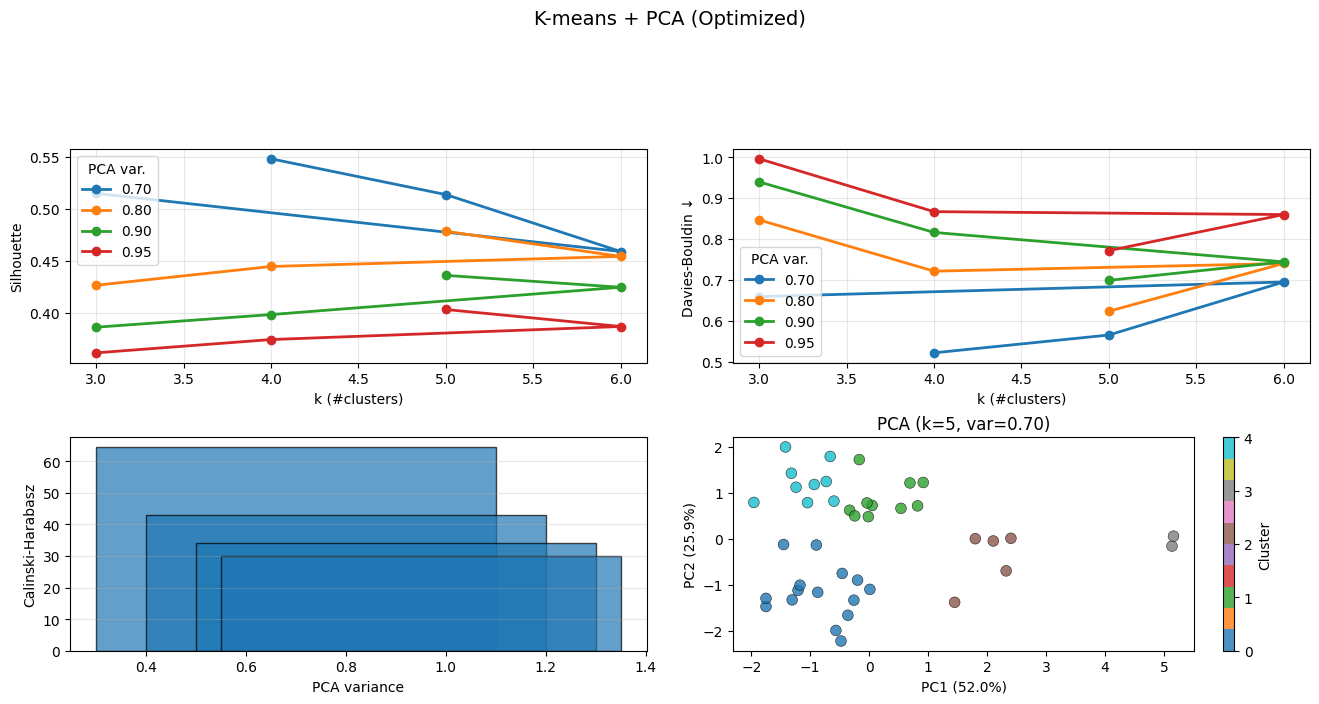

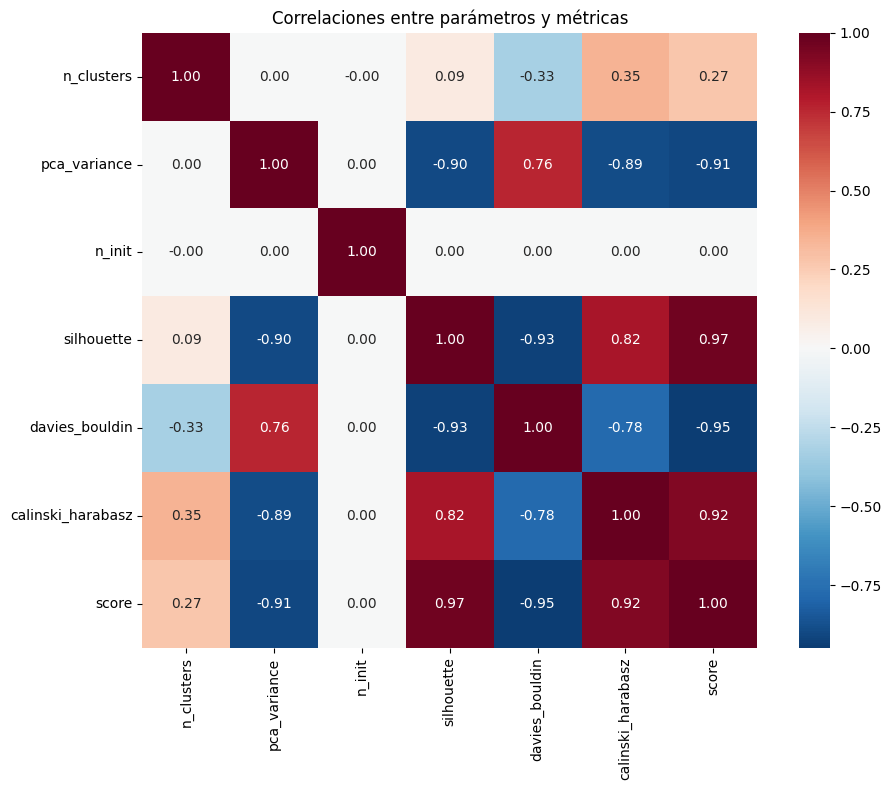

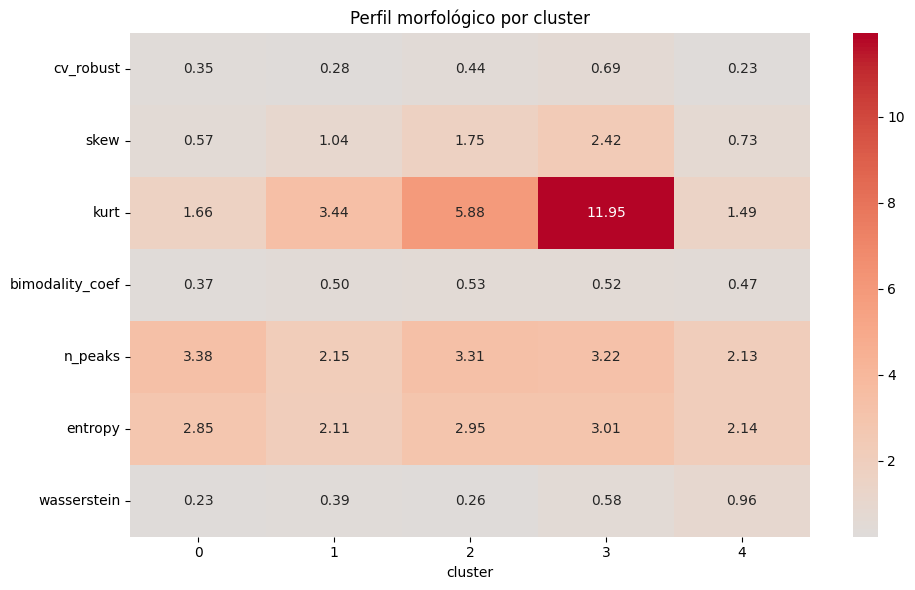


CLUSTERING FINAL — RESUMEN
Parámetros óptimos:
  k = 5
  PCA var = 0.70 (2 componentes)

Métricas:
  Silhouette         : 0.513
  Davies-Bouldin     : 0.565
  Calinski-Harabasz  : 70.1

Distribución de clusters:
cluster
0    15
1    10
2     5
3     2
4     9
Name: count, dtype: int64

✅ Resultados guardados para threshold=0.0


In [41]:
# --------------------------------------------------------------
# 4️⃣ Clustering final
# --------------------------------------------------------------
best = df_grid.iloc[3]
pca_final = PCA(n_components=best['pca_variance'])
X_pca_final = pca_final.fit_transform(X_scaled)

kmeans_final = KMeans(
    n_clusters=int(best['n_clusters']),
    n_init=int(best['n_init']),
    random_state=42
)
df_feat_conn['cluster'] = kmeans_final.fit_predict(X_pca_final)

print(f"\n🎯 Clustering final: k={int(best['n_clusters'])}, "
      f"PCs={pca_final.n_components_}, "
      f"var_PCA={best['pca_variance']:.2f}")

# --------------------------------------------------------------
# 5️⃣ Visualizaciones resumen
# --------------------------------------------------------------

fig1 = plt.figure(figsize=(16, 14))
gs = fig1.add_gridspec(4, 4, hspace=0.35, wspace=0.35)

# (1) Silhouette vs k
ax1 = fig1.add_subplot(gs[0, :2])
for pca_var in sorted(df_grid['pca_variance'].unique()):
    subset = df_grid[(df_grid['pca_variance'] == pca_var) & (df_grid['n_init'] == 100)]
    ax1.plot(subset['n_clusters'], subset['silhouette'], 'o-', label=f'{pca_var:.2f}', lw=2)
ax1.set_xlabel('k (#clusters)')
ax1.set_ylabel('Silhouette')
ax1.legend(title='PCA var.')
ax1.grid(alpha=0.3)

# (2) Davies-Bouldin vs k
ax2 = fig1.add_subplot(gs[0, 2:])
for pca_var in sorted(df_grid['pca_variance'].unique()):
    subset = df_grid[(df_grid['pca_variance'] == pca_var) & (df_grid['n_init'] == 100)]
    ax2.plot(subset['n_clusters'], subset['davies_bouldin'], 'o-', label=f'{pca_var:.2f}', lw=2)
ax2.set_xlabel('k (#clusters)')
ax2.set_ylabel('Davies-Bouldin ↓')
ax2.legend(title='PCA var.')
ax2.grid(alpha=0.3)

# (3) Calinski-Harabasz medio por varianza PCA
ax3 = fig1.add_subplot(gs[1, :2])
grouped = df_grid.groupby('pca_variance')['calinski_harabasz'].mean()
ax3.bar(grouped.index, grouped.values, alpha=0.7, edgecolor='k')
ax3.set_xlabel('PCA variance')
ax3.set_ylabel('Calinski-Harabasz')
ax3.grid(alpha=0.3, axis='y')

# (4) PCA final scatter
ax4 = fig1.add_subplot(gs[1, 2:])
sc = ax4.scatter(
    X_pca_final[:, 0], X_pca_final[:, 1],
    c=df_feat_conn['cluster'], cmap='tab10',
    s=60, alpha=0.8, edgecolors='k', lw=0.4
)
ax4.set_xlabel(f'PC1 ({pca_final.explained_variance_ratio_[0]:.1%})')
ax4.set_ylabel(f'PC2 ({pca_final.explained_variance_ratio_[1]:.1%})')
ax4.set_title(f"PCA (k={int(best['n_clusters'])}, var={best['pca_variance']:.2f})")
plt.colorbar(sc, ax=ax4, label='Cluster')
plt.suptitle('K-means + PCA (Optimized)', fontsize=14)
plt.show()

# --------------------------------------------------------------
# 6️⃣ Heatmaps de correlaciones y perfiles
# --------------------------------------------------------------
fig2, ax = plt.subplots(figsize=(10, 8))
corr_cols = ['n_clusters', 'pca_variance', 'n_init', 'silhouette', 'davies_bouldin', 'calinski_harabasz', 'score']
sns.heatmap(df_grid[corr_cols].corr(), annot=True, fmt='.2f', cmap='RdBu_r', center=0, ax=ax, square=True)
ax.set_title('Correlaciones entre parámetros y métricas')
plt.tight_layout()
plt.show()

# Perfil morfológico por cluster
fig3, ax = plt.subplots(figsize=(10, 6))
cluster_profiles = df_feat_conn.groupby('cluster')[feature_cols].median()
sns.heatmap(cluster_profiles.T, annot=True, fmt='.2f', cmap='coolwarm', center=0, ax=ax)
ax.set_title('Perfil morfológico por cluster')
plt.tight_layout()
plt.show()

# --------------------------------------------------------------
# 7️⃣ Estadísticas finales
# --------------------------------------------------------------
print("\n" + "="*70)
print("CLUSTERING FINAL — RESUMEN")
print("="*70)
print(f"Parámetros óptimos:")
print(f"  k = {int(best['n_clusters'])}")
print(f"  PCA var = {best['pca_variance']:.2f} ({pca_final.n_components_} componentes)")
print("\nMétricas:")
print(f"  Silhouette         : {best['silhouette']:.3f}")
print(f"  Davies-Bouldin     : {best['davies_bouldin']:.3f}")
print(f"  Calinski-Harabasz  : {best['calinski_harabasz']:.1f}")
print("\nDistribución de clusters:")
print(df_feat_conn['cluster'].value_counts().sort_index())
print("="*70)

# --------------------------------------------------------------
# 8️⃣ Guardado de resultados
# --------------------------------------------------------------
threshold = 0.0  # o 0.0 / 0.4 según el dataset
df_grid.to_csv(f'gridsearch_kmeans_th_{threshold}.csv', index=False)
df_feat_conn.to_csv(f'feature_clusters_th_{threshold}.csv', index=False)
print(f"\n✅ Resultados guardados para threshold={threshold}")

In [49]:
df_grid

,n_clusters,n_init,pca_variance,n_pcs,silhouette,davies_bouldin,calinski_harabasz,inertia,score
6,3,50,0.80,3,0.331337,1.074116,23.317712,106.342963,1.689635
9,3,100,0.80,3,0.331337,1.074116,23.317712,106.342963,1.689635
18,5,50,0.80,3,0.312090,1.020961,23.934680,67.740750,1.664082
21,5,100,0.80,3,0.312090,1.020961,23.934680,67.740750,1.664082
12,4,50,0.80,3,0.337631,1.088519,22.332635,86.245911,1.576479
15,4,100,0.80,3,0.337631,1.088519,22.332635,86.245911,1.576479
22,5,100,0.90,4,0.323930,1.010744,22.204093,78.056843,1.549019
19,5,50,0.90,4,0.323930,1.010744,22.204093,78.056843,1.549019
16,4,100,0.90,4,0.319734,1.069741,20.947883,98.098521,1.169396
13,4,50,0.90,4,0.319734,1.069741,20.947883,98.098521,1.169396


In [33]:
df_feat_conn

,roi_i,roi_j,pair_label,cv_robust,skew,kurt,bimodality_coef,n_peaks,entropy,wasserstein,cluster
0,4,35,"L-Lateral lemniscus → L-Hypothalamic region, u...",0.239400,0.671131,1.452492,0.441646,2.000000,2.098549,0.797945,5
1,8,29,L-Substantia nigra → L-Subiculum,0.287964,0.913039,1.865025,0.509629,1.928571,2.062341,0.386813,2
2,9,35,"L-Zona incerta → L-Hypothalamic region, unspec...",0.624365,2.321130,12.707726,0.466287,3.444444,2.865893,0.529290,3
3,9,42,L-Zona incerta → L-Bed nucleus of the stria te...,0.428430,1.867939,6.270494,0.517481,4.888889,2.943807,0.360664,1
4,12,53,L-Parietal association cortex → L-Ventral stri...,0.753708,2.438674,10.210729,0.585528,2.777778,3.119642,0.625522,3
5,24,35,"L-GENv → L-Hypothalamic region, unspecified",0.534854,0.879158,1.617898,0.464966,2.833333,2.553633,0.174167,4
6,26,58,L-Nucleus accumbens → L-Primary motor area,0.274118,0.990655,1.985041,0.477665,2.722222,2.355725,1.065934,5
7,28,29,L-Hippocampus → L-Subiculum,0.352666,1.818051,6.571736,0.521678,3.388889,2.922843,0.264572,1
8,28,35,"L-Hippocampus → L-Hypothalamic region, unspeci...",0.344206,0.362065,1.291131,0.363031,4.055556,2.940697,0.298468,0
9,29,42,L-Subiculum → L-Bed nucleus of the stria termi...,0.356734,1.810497,6.208453,0.521806,3.055556,3.034182,0.269568,1


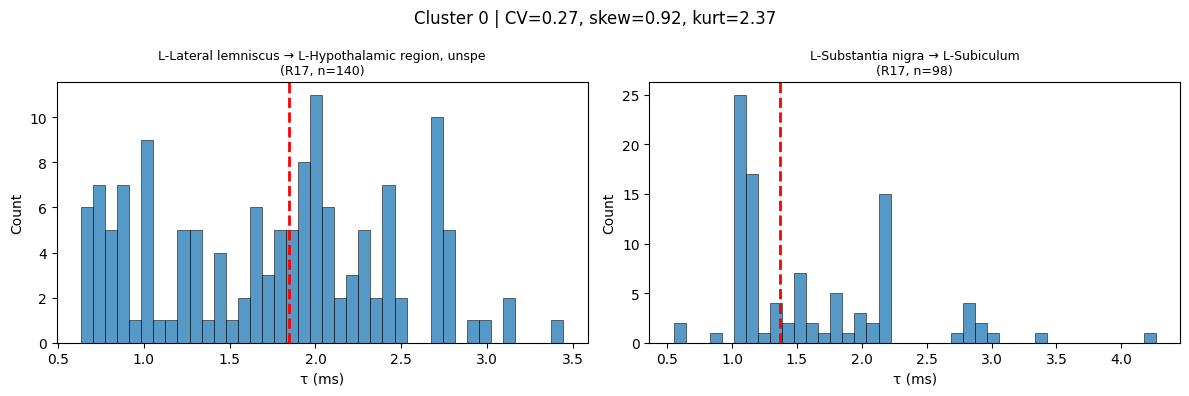

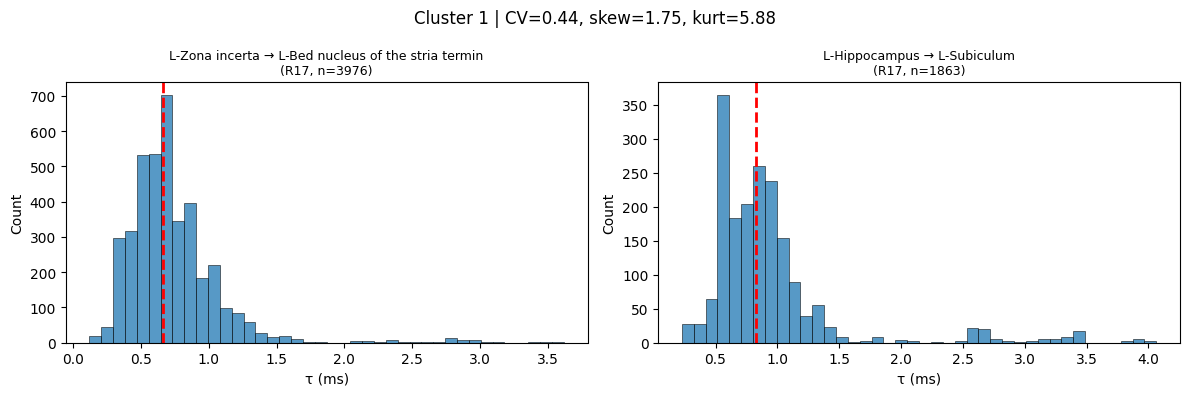

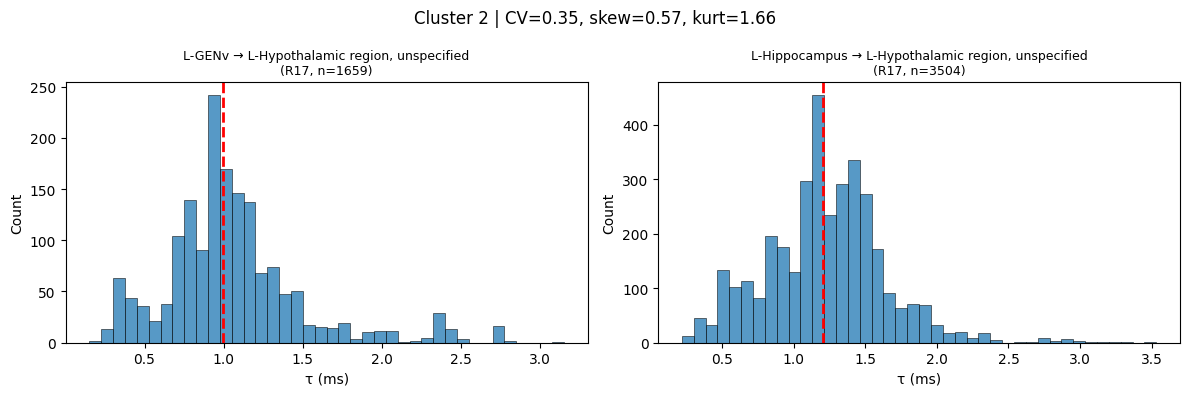

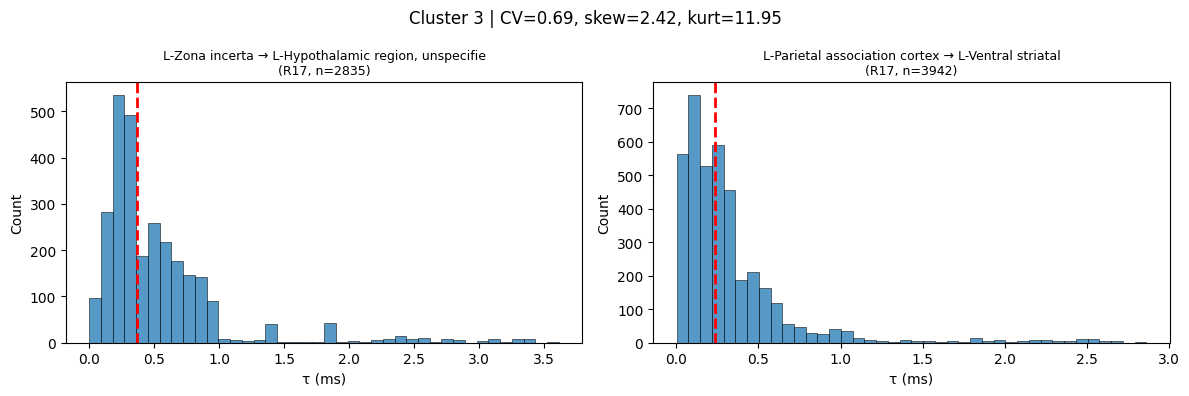

In [38]:
# Ejemplos por cluster
np.random.seed(42)

for c in sorted(df_feat_conn['cluster'].unique()):
    # Seleccionar 2 conexiones del cluster
    cluster_conns = df_feat_conn[df_feat_conn['cluster'] == c].head(2)
    
    if len(cluster_conns) == 0:
        continue
    
    n_plots = len(cluster_conns)
    fig, axes = plt.subplots(1, n_plots, figsize=(6*n_plots, 4))
    if n_plots == 1:
        axes = [axes]
    
    cluster_profile = df_feat_conn[df_feat_conn['cluster'] == c][feature_cols].median()
    
    for idx, (_, row) in enumerate(cluster_conns.iterrows()):
        i, j = int(row['roi_i']), int(row['roi_j'])
        
        # Tomar primera rata disponible para esta conexión
        rat_id = None
        for rid, data in cleaned_rats.items():
            if (i, j) in data:
                rat_id = rid
                break
        
        if rat_id is None:
            continue
            
        tau_ms = cleaned_rats[rat_id][(i,j)][:, COL_TAU] * 1e3
        
        axes[idx].hist(tau_ms, bins=40, alpha=0.75, edgecolor='k', linewidth=0.5)
        axes[idx].axvline(np.median(tau_ms), color='r', ls='--', lw=2)
        axes[idx].set_title(f"{row['pair_label'][:50]}\n({rat_id}, n={len(tau_ms)})", fontsize=9)
        axes[idx].set_xlabel('τ (ms)')
        axes[idx].set_ylabel('Count')
    
    fig.suptitle(
        f'Cluster {c} | CV={cluster_profile["cv_robust"]:.2f}, '
        f'skew={cluster_profile["skew"]:.2f}, kurt={cluster_profile["kurt"]:.2f}',
        fontsize=12
    )
    plt.tight_layout()
    plt.show()

Evaluando 16 configuraciones...


/home/ubuntu-deduce/Projects/izhikevich/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ubuntu-deduce/Projects/izhikevich/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ubuntu-deduce/Projects/izhikevich/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ubuntu-deduce/Projects/izhikevich/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ubuntu-deduce/Projects/izhikevich/.venv/lib/python3.10/site-packages/sklea


✓ Grid search completo: 16 configuraciones válidas

Top 5 configuraciones:
 n_neighbors  min_dist  min_cluster_size  min_samples  n_clusters  silhouette  noise_pct
          20       0.0               100            5           3    0.551319   5.088757
          20       0.0               100           10           3    0.543617   5.088757
          10       0.0               100           10           3    0.541492   7.100592
          10       0.0               100            5           3    0.556812  15.976331
          20       0.2                10            5           2    0.537661   0.000000


/home/ubuntu-deduce/Projects/izhikevich/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ubuntu-deduce/Projects/izhikevich/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Clustering final: 2 clusters + 43 noise


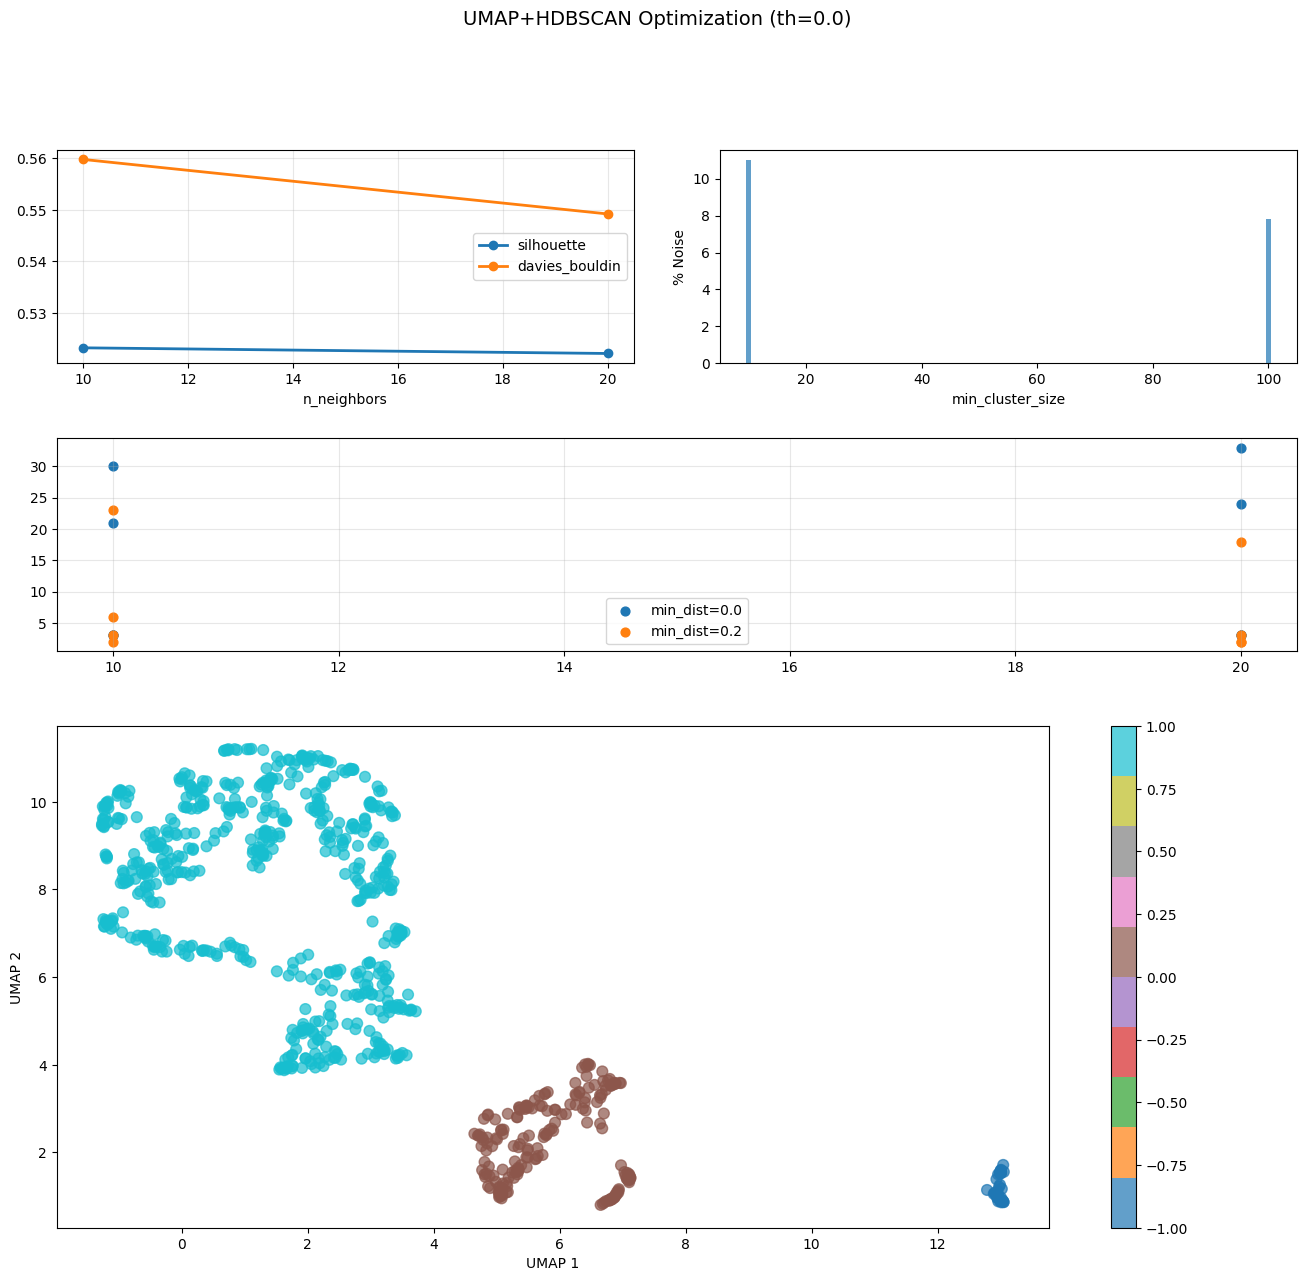

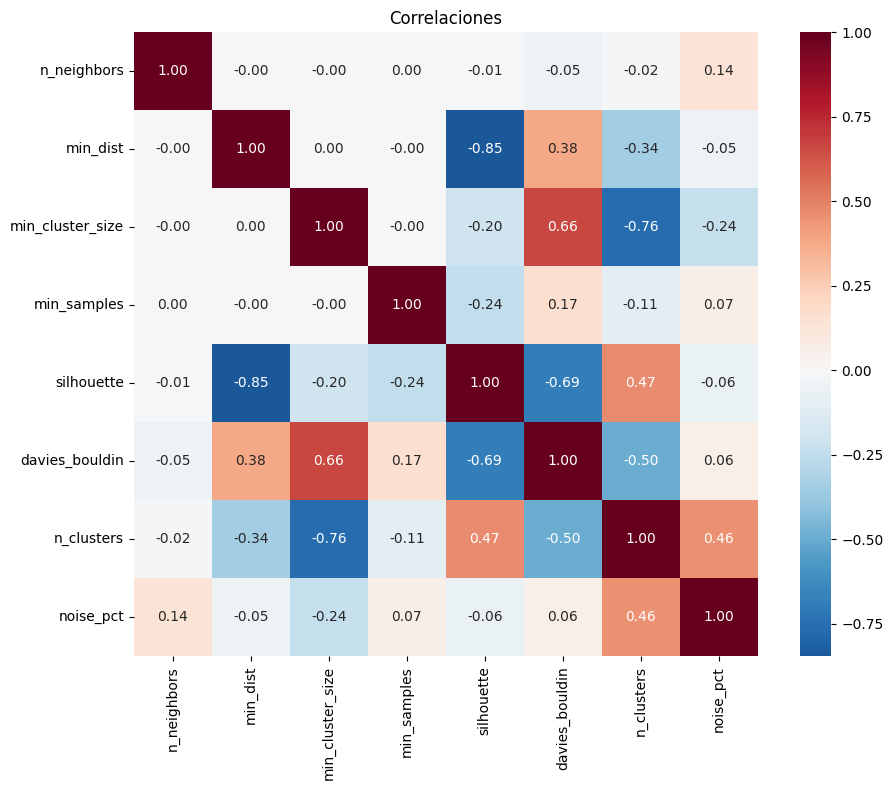

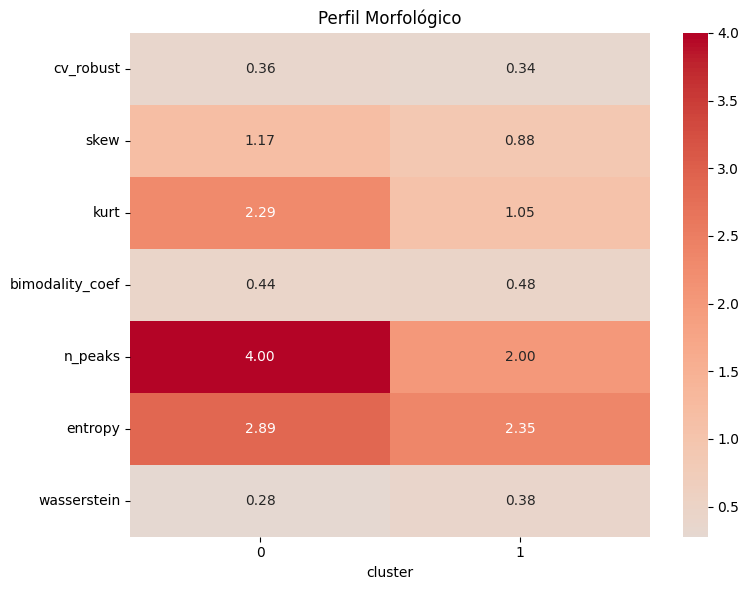


ESTADÍSTICAS CLUSTERING FINAL
Parámetros óptimos:
  n_neighbors=20, min_dist=0.0
  min_cluster_size=100, min_samples=5

Métricas:
  Silhouette: 0.551
  Davies-Bouldin: 0.581
  Calinski-Harabasz: 2002.1
  Noise: 5.1%

Distribución por cluster:
cluster
-1     43
 0    191
 1    611
Name: count, dtype: int64


In [ ]:

# Caracterizar
top_pairs = [(r['roi_i'], r['roi_j']) for _, r in df_stable_diverse.head(50).iterrows()]
df_feat = characterize_distributions_enhanced(cleaned_rats, top_pairs)

# Features para clustering (robustos a outliers)
X = df_feat[['cv_robust', 'skew', 'bimodality_coef', 'iqr_norm', 'wasserstein', 'ks_stat', 'mean', 'median', 'kurt', 'n_peaks', 'entropy', 'kl_div', 'range_norm']].values

feature_cols = ['cv_robust', 'skew', 'kurt', 'bimodality_coef', 
                'n_peaks', 'entropy', 'wasserstein']

corr_cols = ['n_neighbors', 'min_dist', 'min_cluster_size', 'min_samples',
             'silhouette', 'davies_bouldin', 'n_clusters', 'noise_pct']

X = df_feat[feature_cols].dropna().values
X_scaled = RobustScaler().fit_transform(X)

# ===== GRID SEARCH =====
param_grid = {
    'n_neighbors': [10, 20],
    'min_dist': [0.0, 0.2],
    'min_cluster_size': [10, 100],  # más grande → menos clusters
    'min_samples': [5, 10]
}

results = []
print(f"Evaluando {len(list(ParameterGrid(param_grid)))} configuraciones...")

for i, params in enumerate(ParameterGrid(param_grid)):
    # UMAP
    reducer = UMAP(n_neighbors=params['n_neighbors'], 
                   min_dist=params['min_dist'],
                   n_components=2, n_jobs=-1)
    X_umap = reducer.fit_transform(X_scaled)
    
    # HDBSCAN
    clusterer = HDBSCAN(min_cluster_size=params['min_cluster_size'],
                        min_samples=params['min_samples'], 
                        core_dist_n_jobs=-1)
    labels = clusterer.fit_predict(X_umap)
    
    # Métricas (solo no-ruido)
    mask = labels != -1
    n_noise = (~mask).sum()
    n_clustered = mask.sum()
    n_clusters = len(set(labels[mask])) if n_clustered > 0 else 0
    
    if n_clustered > 20 and n_clusters > 1:
        sil = silhouette_score(X_umap[mask], labels[mask])
        db = davies_bouldin_score(X_umap[mask], labels[mask])
        ch = calinski_harabasz_score(X_umap[mask], labels[mask])
        noise_pct = 100 * n_noise / len(labels)
        
        results.append({
            **params, 
            'silhouette': sil, 
            'davies_bouldin': db,
            'calinski_harabasz': ch,
            'n_clusters': n_clusters, 
            'noise_pct': noise_pct,
            'n_clustered': n_clustered
        })
    
    if (i+1) % 20 == 0:
        print(f"  {i+1}/{len(list(ParameterGrid(param_grid)))} completado")

df_grid = pd.DataFrame(results)

# Mejor configuración (multiobjetivo)
# Cambiar función de score
df_grid['score'] = (
    df_grid['silhouette'] / df_grid['silhouette'].max() - 
    df_grid['davies_bouldin'] / df_grid['davies_bouldin'].max() +
    df_grid['calinski_harabasz'] / df_grid['calinski_harabasz'].max() -
    df_grid['noise_pct'] / 100 -
    abs(df_grid['n_clusters'] - 4) / 10  # penaliza alejarse de k=4
)
df_grid = df_grid.sort_values('score', ascending=False)

print(f"\n✓ Grid search completo: {len(df_grid)} configuraciones válidas")
print("\nTop 5 configuraciones:")
print(df_grid.head(5)[['n_neighbors', 'min_dist', 'min_cluster_size', 'min_samples', 
                        'n_clusters', 'silhouette', 'noise_pct']].to_string(index=False))

# ===== CLUSTERING FINAL =====
best = df_grid.iloc[0]
reducer_final = UMAP(n_neighbors=int(best['n_neighbors']), 
                     min_dist=best['min_dist'],
                     n_components=2, random_state=42)
X_umap_final = reducer_final.fit_transform(X_scaled)

clusterer_final = HDBSCAN(min_cluster_size=int(best['min_cluster_size']),
                          min_samples=int(best['min_samples']))
df_feat['cluster'] = clusterer_final.fit_predict(X_umap_final)

mask_final = df_feat['cluster'] != -1
print(f"\nClustering final: {df_feat['cluster'].nunique()-1} clusters + {(~mask_final).sum()} noise")

# ===== PLOTS PRINCIPALES (4x4) =====
fig1 = plt.figure(figsize=(16, 14))
gs = fig1.add_gridspec(4, 4, hspace=0.35, wspace=0.35)

# Fila 1: Métricas vs parámetros
ax1 = fig1.add_subplot(gs[0, :2])
for metric in ['silhouette', 'davies_bouldin']:
    grouped = df_grid.groupby('n_neighbors')[metric].mean()
    ax1.plot(grouped.index, grouped.values, 'o-', label=metric, lw=2)
ax1.set_xlabel('n_neighbors'); ax1.legend(); ax1.grid(alpha=0.3)

ax2 = fig1.add_subplot(gs[0, 2:])
grouped = df_grid.groupby('min_cluster_size')['noise_pct'].mean()
ax2.bar(grouped.index, grouped.values, alpha=0.7)
ax2.set_xlabel('min_cluster_size'); ax2.set_ylabel('% Noise')

# Fila 2: Scatter n_clusters
ax3 = fig1.add_subplot(gs[1, :])
for md in sorted(df_grid['min_dist'].unique()):
    subset = df_grid[df_grid['min_dist'] == md]
    ax3.scatter(subset['n_neighbors'], subset['n_clusters'], 
               label=f'min_dist={md}', s=40)
ax3.legend(); ax3.grid(alpha=0.3)

# Fila 3-4: UMAP grande
ax4 = fig1.add_subplot(gs[2:, :])
scatter = ax4.scatter(X_umap_final[:, 0], X_umap_final[:, 1], 
                     c=df_feat['cluster'], cmap='tab10', s=60, alpha=0.7)
ax4.set_xlabel('UMAP 1'); ax4.set_ylabel('UMAP 2')
plt.colorbar(scatter, ax=ax4)

plt.suptitle(f'UMAP+HDBSCAN Optimization (th=0.0)', fontsize=14)
plt.savefig(f'clustering_main_th_0.0.png', dpi=150, bbox_inches='tight')
plt.show()

# ===== HEATMAPS SEPARADOS =====
# Correlaciones
fig2, ax = plt.subplots(1, 1, figsize=(10, 8))
corr_matrix = df_grid[corr_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', 
            center=0, ax=ax, square=True)
ax.set_title('Correlaciones')
plt.tight_layout()
plt.savefig(f'correlations_th_0.0.png', dpi=150)
plt.show()

# Perfil clusters
fig3, ax = plt.subplots(1, 1, figsize=(8, 6))
cluster_profiles = df_feat[mask_final].groupby('cluster')[feature_cols].median()
sns.heatmap(cluster_profiles.T, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, ax=ax)
ax.set_title('Perfil Morfológico')
plt.tight_layout()
plt.savefig(f'profiles_th_0.0.png', dpi=150)
plt.show()

# ===== ESTADÍSTICAS FINALES =====
print("\n" + "="*70)
print("ESTADÍSTICAS CLUSTERING FINAL")
print("="*70)
print(f"Parámetros óptimos:")
print(f"  n_neighbors={int(best['n_neighbors'])}, min_dist={best['min_dist']}")
print(f"  min_cluster_size={int(best['min_cluster_size'])}, min_samples={int(best['min_samples'])}")
print(f"\nMétricas:")
print(f"  Silhouette: {best['silhouette']:.3f}")
print(f"  Davies-Bouldin: {best['davies_bouldin']:.3f}")
print(f"  Calinski-Harabasz: {best['calinski_harabasz']:.1f}")
print(f"  Noise: {best['noise_pct']:.1f}%")
print(f"\nDistribución por cluster:")
print(df_feat['cluster'].value_counts().sort_index())

In [ ]:
# 2 ejemplos por cluster
np.random.seed(42)
for c in sorted(df_feat['cluster'].unique()):
    # Tomar 2 pares distintos del cluster
    cluster_pairs = df_feat[df_feat['cluster'] == c][['roi_i', 'roi_j', 'rat_id']].drop_duplicates(['roi_i', 'roi_j']).head(2)
    
    if len(cluster_pairs) == 0:
        continue
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    cluster_profile = df_feat[df_feat['cluster'] == c][['cv_robust', 'skew', 'n_peaks']].median()
    
    for idx, (_, row) in enumerate(cluster_pairs.iterrows()):
        i, j, rat = int(row['roi_i']), int(row['roi_j']), row['rat_id']
        tau_ms = cleaned_rats[rat][(i,j)][:, COL_TAU] * 1e3
        
        axes[idx].hist(tau_ms, bins=40, alpha=0.75, edgecolor='k', linewidth=0.5)
        axes[idx].axvline(np.median(tau_ms), color='r', ls='--', lw=2)
        axes[idx].set_title(f"{roi_label(i, name_map)[:25]}\n→ {roi_label(j, name_map)[:25]}", fontsize=9)
        axes[idx].set_xlabel('τ (ms)')
    
    fig.suptitle(f'Cluster {c} | CV={cluster_profile["cv_robust"]:.2f}, skew={cluster_profile["skew"]:.2f}, peaks={cluster_profile["n_peaks"]:.0f}', fontsize=12)
    plt.tight_layout()
    plt.show()